In [469]:
from IPython.display import HTML

HTML('''
<style>
    .cell.code_cell .input {display: none;}
</style>
''')

# ADDAM clustering: replication analysis In the Second Batch (205 samples)

We conducted clustering analysis on the second batch of samples based on their clinical, genotype and antibody data, in order to replicate our findings on the first batch of samples.

Conclusion:

* We first tried simple K-means clustering, and find the clustering was most driven by the genotype profiles. Specifically, 2 SNPs (rs2395228 and rs1049124) in MHC region are found significantly associated with K-means clustering paterns, and these 2 SNPs are also found in the previous clustering analysis of the first batch of samples.

* We then tried the hierarchical clustering. The clustering results was driven by exactly the same two SNPs from the MHC region. In addition, Hierarchial clustering also identified IA2 antibody as a significant feature for clustering.

* Finally we tried the Fuzzy C-means clustering, and the clustering was driven by the 5 SNPs from MHC region.  The same two SNPs (rs2395228 and rs1049124) also appear in the feature list for clustering. In addition, the IA2 qual is significantly associate with Fuzzy C-means clustering, but IA2 index is not.

* Note that all the three clustering methods are consistently align with the top 2 principle components of the PCA analysis.

* The UMAP analysis did not show anything interesting.

* Blockers: there are patients in this batch missing antibody data, which reduced the antibody analysis power. The sample IDs with missing antibody data is attached in "cluster_2025_B2_missing_subjects.txt" for verficiation. We strongly suggest to send us the updated antibody data for these patients.

## Genotype Data Processing 

* We first collected the genotype data of the second batch of 207 samples. 

* We processed the genotype data and imputed the genotypes of the 72 SNPs that are used in the type 1 diabetes GRS2. The imputation is done with the TopMed imputation platform. 

* 205 samples passed the quality control and were used in the clustering analysis.







In [ ]:
import pandas as pd
import pandas_plink


#genotypes of second batch
file_path = 'dat/merged_extracted_from_bim'

(bim, fam, bed) = pandas_plink.read_plink(file_path)


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 14.82it/s]


## Clinical data Processing


We then collect the clinical information of the 205 samples. 


Note that 200 out of 205 samples are avaialble in the clinical database. 5 samples missing from the clinical database.

We manually curated the following 12 features for clustering:

* patients age 
* patients sex (at birth)
* diabete histories (date of dianosis to date 1 Oct, 2024)
* diabetes in siblings (yes or no, 0 or 1) N = 47
* diabetes in father (0 or 1)   N = 38
* diabetes in mother (0 or 1)   N = 30
* patients father or mother have diabetes (yes or no, 0 or 1)  N = 62
* patients first degree relatives have diabetes AND diabetes in other family members. N = 34 
* height
* weight
* insulin dosages
* A1c results in average

Note that we updated the sex column with the clinical information from November.


In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

clinical_data = pd.read_csv('dat/cluster_clinical.csv')

print("Clinical features curation:")
print(clinical_data.columns)

cluster_subject_id = fam['iid']

#print(cluster_subject_id[0:10])


# Subset the combined_data by the cluster_subject_id
clinical_data = clinical_data[clinical_data['Cluster_subjectID'].isin(cluster_subject_id)]


#which subjects are missing from the clinical data?
missing_subjects = cluster_subject_id[~cluster_subject_id.isin(clinical_data['Cluster_subjectID'])]

print("5 samples are missing clinical information:")
print(missing_subjects)


cluster_subject_id = cluster_subject_id[cluster_subject_id.isin(clinical_data['Cluster_subjectID'])]

print("Number of samples with both genotype and clinical information:")

print(len(cluster_subject_id.unique()))



Clinical features curation:
Index(['Cluster_age', 'Cluster_diabete_history', 'Cluster_sex',
       'Cluster_diabetes_siblings', 'Cluster_diabetes_father',
       'Cluster_diabetes_mother', 'Cluster_diabetes_parents',
       'Cluster_family_diabetes', 'Cluster_subjectID', 'Cluster_height',
       'Cluster_weight', 'Cluster_insulin', 'Cluster_A1c'],
      dtype='object')
5 samples are missing clinical information:
95     01-315-02
201    01-424-01
202      NA12146
203      NA10830
204      NA12236
Name: iid, dtype: string
Number of samples with both genotype and clinical information:
200


In [ ]:
#we update the sex information

#load the updated clinical information csv file
clinical_info_updates = pd.read_csv('dat/ADDAM_clustering_MCh_participants_Nov13.csv')

#print(clinical_info_updates.shape)

#rename the column name of the 4th column to "sex_birth"
clinical_info_updates.columns.values[3] = "sex_birth"
clinical_info_updates.columns.values[0] = "Cluster_subjectID"

# Print table counts of sex_birth in clinical_info_updates
cluster_sex_counts = clinical_info_updates['sex_birth'].value_counts()
#print("The table counts of the sex at birth record of the 110 subjects for clustering analysis:")
#print(cluster_sex_counts)

#subset the dataframe with only Subject and sex_birth
clinical_info_updates = clinical_info_updates[['Cluster_subjectID','sex_birth']]
#merge the updated clinical information with the merged data, only keep the rows that are in the merged data
merged_data_sex = pd.merge(clinical_data, clinical_info_updates, on='Cluster_subjectID', how='inner')


merged_data_sex = merged_data_sex.drop(columns = ['Cluster_sex'])
#rename sex_birth to Cluster_sex
merged_data_sex.rename(columns={"sex_birth": "Cluster_sex"}, inplace=True)


#binarize the Cluster_sex to 0 and 1, 0 for female and 1 for male
merged_data_sex['Cluster_sex'] = merged_data_sex["Cluster_sex"].apply(lambda x: 1 if x == "Male" else 0)

#save the updated clinical information merged_data_sex to a csv file
merged_data_sex.to_csv('results/cluster_2025_B2_merged_data_sex.csv', index=False)



We then collect the antibody data of the 200 sample for the three types of antibodies: 96GAD, IA2, and ZnT8.

Note that 130 of the samples can be found in the antibody data, and 70 samples are missing in the antibody data. The missing sample ID is provided in the file "cluster_2025_B2_missing_subjects.txt" for verification.


In [ ]:
import pandas as pd

antibody_data = pd.read_csv('dat/antibody_filtered.csv')

print("Antibody data format:")
print(antibody_data.columns)


#remove the space and special characters from the column Subject
antibody_data['Subject'] = antibody_data['Subject'].str.replace(' ', '')
antibody_data['Subject'] = antibody_data['Subject'].str.replace('\xa0', '').str.strip()


Antibody data format:
Index(['Subject', 'Draw Date', '96GAD Qual', '96GAD Index', 'IA2 Qual',
       'IA2 Index', 'ZnT8 Qual', 'ZnT8 Index'],
      dtype='object')


In [ ]:
#now we match the genotype data with the clinical data, antibody data
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# Assuming 'fam' and 'combined_data' are already loaded

# Subset the combined_data by the cluster_subject_id
cluster_antibody_data = antibody_data[antibody_data['Subject'].isin(cluster_subject_id)]



# Antibody list of columns to work with
columns_antibody_list = ['96GAD Qual', '96GAD Index', 'Draw Date', 'IA2 Qual', 'IA2 Index', 'ZnT8 Qual', 'ZnT8 Index']

cluster_antibody_data['Draw Date'] = pd.to_datetime(cluster_antibody_data['Draw Date'])

# Sort data by 'Subject' and 'Draw Date' in descending order 
cluster_antibody_data = cluster_antibody_data.sort_values(by=['Subject', 'Draw Date'], ascending=[True, False])


print("Unique Subject in the combined antibody data:", len(cluster_antibody_data['Subject'].unique()))

# Function to get the most recent non-missing value for each antibody column
def get_most_recent_non_missing(group):
    # Initialize a dictionary to store the most recent non-missing values
    result = {'Subject': group['Subject'].iloc[0], 'Draw Date': group['Draw Date'].iloc[0]}
    
    # Define valid values for the 'Qual' columns
    valid_qual_values = ['POS', 'neg']
    
    # Process each column
    for col in columns_antibody_list:
        if col in ['96GAD Qual', 'IA2 Qual', 'ZnT8 Qual']:
            result[col] = next((val for val in group[col] if val in valid_qual_values), None)
        else:
            result[col] = group[col].dropna().iloc[0] if not group[col].dropna().empty else None
    return pd.Series(result)

most_recent_antibodies = cluster_antibody_data.groupby('Subject').apply(get_most_recent_non_missing)

print(" matched subject (genotype, clinical and antibody) antibody data dimension:", most_recent_antibodies.shape)

most_recent_antibodies.to_csv('results/cluster_2025_B2_antibody_final.csv', index=False)



#the Subject that in cluster_subject_id but not in most_recent_antibodies
missing_subjects = cluster_subject_id[~cluster_subject_id.isin(most_recent_antibodies['Subject'])]
print("Number of missing subjects among 200 samples without antibody records:", missing_subjects.shape[0])


#writ these missing_subjects to a txt file to contact Angeliki
missing_subjects.to_csv('results/cluster_2025_B2_missing_subjects.txt', index=False)

print("The missing subjects are saved to cluster_2025_B2_missing_subjects.txt")


Unique Subject in the combined antibody data: 130
 matched subject (genotype, clinical and antibody) antibody data dimension: (130, 8)
Number of missing subjects among 200 samples without antibody records: 70
The missing subjects are saved to cluster_2025_B2_missing_subjects.txt


For genotype data, we create a matrix of 130 X 216, where 130 is the number of samples and 72 is the number of SNPs. Each SNP have 3 genotype status: 0, 1, 2, corresponding to homozygous, heterozygous, and homozygous respectively.


In [ ]:
import pandas as pd

snp_names = bim['snp'].tolist()  # Replace 'snp' with the actual column containing SNP names in bim

genotype_data = bed.compute()  # Load the genotype data

genotype_df = pd.DataFrame(genotype_data, index=snp_names)

genotype_df.columns = fam['iid']

num_rows, num_cols = genotype_df.shape

new_df = pd.DataFrame(index=range(num_rows * 3), columns=range(num_cols))

for i in range(num_rows):
    # Get the current row of genotype_df
    current_row = genotype_df.iloc[i]
    
    # First row: elements equal to 1
    new_df.iloc[i * 3] = (current_row == 1).astype(int)
    
    #  elements equal to 2
    new_df.iloc[i * 3 + 1] = (current_row == 2).astype(int)
    
    # Third row: elements equal to 3
    new_df.iloc[i * 3 + 2] = (current_row == 3).astype(int)

# Transpose the new DataFrame
transposed_df = new_df.T


transposed_df['Subject'] =  fam['iid']

#save transposed_df in csv file
transposed_df.to_csv('results/cluster_2025_B2_genotype.csv', index=False)

#print(transposed_df.shape)


The predicted ancestry for the 130 samples are shown in the Figure 1. 

The top three predicted ancestrys in the sample are:

* MXL:	Mexican Ancestry from Los Angeles USA
* CEU: Utah Residents (CEPH) with Northern and Western European Ancestry
* TSI:  Toscani in Italia

Note that the TSI (green) and CEU (blue) are both White European population, therefore we create a new column Ancestry_EUR to represent the European White population. We then coded the ancestry information into 4 columns: Ancestry_MXL, Ancestry_TSI, Ancestry_CEU, Ancestry_EUR. The Ancestry_EUR is created to represent European White population. A sample is assigned value 1 if it is predicted to be from that ancestry, and 0 otherwise. 

Note the ancestry prediction is based on the first two principal components from the genotype data. The prediction is based on the nearest neighbor method using the HapMapIII data as the reference set.

The table counts of the Predicted_Ancestry:
Predicted_Ancestry
MXL    63
CEU    28
TSI    22
ASW     9
GIH     7
CHB     1
Name: count, dtype: int64


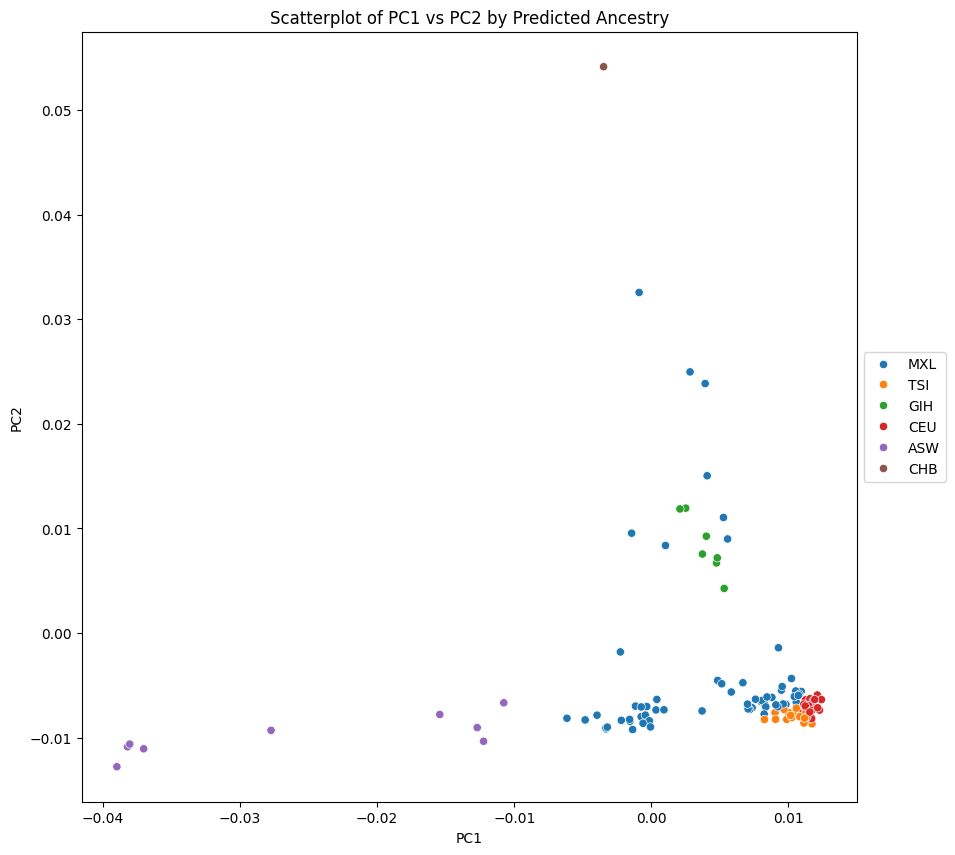

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Load the spreadsheet data with ancestry information
ancestry_info_updates = pd.read_csv('dat/annotated_ancestry_ADDAM2.csv')

subset_ancestry = ancestry_info_updates[ancestry_info_updates['IID'].isin(cluster_antibody_data['Subject'])].copy()

print("The table counts of the Predicted_Ancestry:")
print(subset_ancestry['Predicted_Ancestry'].value_counts())

# Plot scatterplot of "PC1" and "PC2", colored by "Color"
plt.figure(figsize=(10, 10))
sns.scatterplot(data=subset_ancestry, x="PC1", y="PC2", hue="Predicted_Ancestry")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Scatterplot of PC1 vs PC2 by Predicted Ancestry')
plt.show()

# Code the ancestry information into 4 columns: Ancestry_MXL, Ancestry_TSI, Ancestry_CEU
ancestry_dict = {'MXL': 'Ancestry_MXL', 'TSI': 'Ancestry_TSI', 'CEU': 'Ancestry_CEU'}
for key, value in ancestry_dict.items():
    subset_ancestry.loc[:, value] = subset_ancestry["Predicted_Ancestry"].apply(lambda x: 1 if x == key else 0)

# Create a new column Ancestry_EUR, which is the sum of Ancestry_TSI and Ancestry_CEU
subset_ancestry.loc[:, 'Ancestry_EUR'] = subset_ancestry['Ancestry_TSI'] + subset_ancestry['Ancestry_CEU']

# Keep only the necessary columns
subset_ancestry = subset_ancestry[['IID', 'Ancestry_MXL', 'Ancestry_EUR', 'Ancestry_TSI', 'Ancestry_CEU']]

#save merged_data_sex_ancestry
subset_ancestry.to_csv('results/2025_ancestry_final.csv', index=False)

We finally combine the genotype data, clinical data and antibody data for the overlapping samples N = 130.

After combing three datasets, in addition to the column of subject ID, we have a numeric feature matrix of 130 X 234, where 130 is the number of samples and 234 is the number of features:

* 216 genotype features
* 12 clinical features
* 6 antibody features
* 4 ancestry features



In [ ]:
import pandas as pd
import warnings

# Load the genotype data
genotype_data = pd.read_csv('results/cluster_2025_B2_genotype.csv')

#load clinical data
clinical_data = pd.read_csv('results/cluster_2025_B2_merged_data_sex.csv')
#rename Cluster_subjectID to Subject
clinical_data = clinical_data.rename(columns={'Cluster_subjectID': 'Subject'})

#load antibody data
antibody_data = pd.read_csv('results/cluster_2025_B2_antibody_final.csv')

#load ancestry data 
ancestry_data = pd.read_csv('results/2025_ancestry_final.csv')
ancestry_data = ancestry_data.rename(columns={'IID': 'Subject'})

# Step 1: Find the overlapping Subject IDs
overlapping_subjects = set(genotype_data['Subject']).intersection(
    set(clinical_data['Subject'])).intersection(set(antibody_data['Subject']))

overlapping_subjects = list(overlapping_subjects)

print("number of subjects in the overlapping dataset:")
print(len(overlapping_subjects))

# Step 2: Subset the datasets to include only the overlapping Subject IDs
genotype_subset = genotype_data[genotype_data['Subject'].isin(overlapping_subjects)]
clinical_subset = clinical_data[clinical_data['Subject'].isin(overlapping_subjects)]
antibody_subset = antibody_data[antibody_data['Subject'].isin(overlapping_subjects)]
ancestry_subset = ancestry_data[ancestry_data['Subject'].isin(overlapping_subjects)]

      
# Step 3: Merge the datasets on the 'Subject' column
merged_data = genotype_subset.merge(clinical_subset, on='Subject').merge(antibody_subset, on='Subject').merge(ancestry_subset, on='Subject')



#remove the Draw Date column
merged_data = merged_data.drop('Draw Date', axis=1)

#replace the POS and neg with 1 and 0 numerics
merged_data['96GAD Qual'] = merged_data['96GAD Qual'].replace({'POS': 1, 'neg': 0})
merged_data['IA2 Qual'] = merged_data['IA2 Qual'].replace({'POS': 1, 'neg': 0})
merged_data['ZnT8 Qual'] = merged_data['ZnT8 Qual'].replace({'POS': 1, 'neg': 0})


#save 
merged_data.to_csv('results/2025_cluster_March_merged.csv', index=False)


number of subjects in the overlapping dataset:
130


## Descriptive Statistics 

We first conducted the descriptive statistics on the 130 samples for the features of interest. 

In conclusion, we found some interesting patterns in the data:


* there are 3 subjects with age > 30

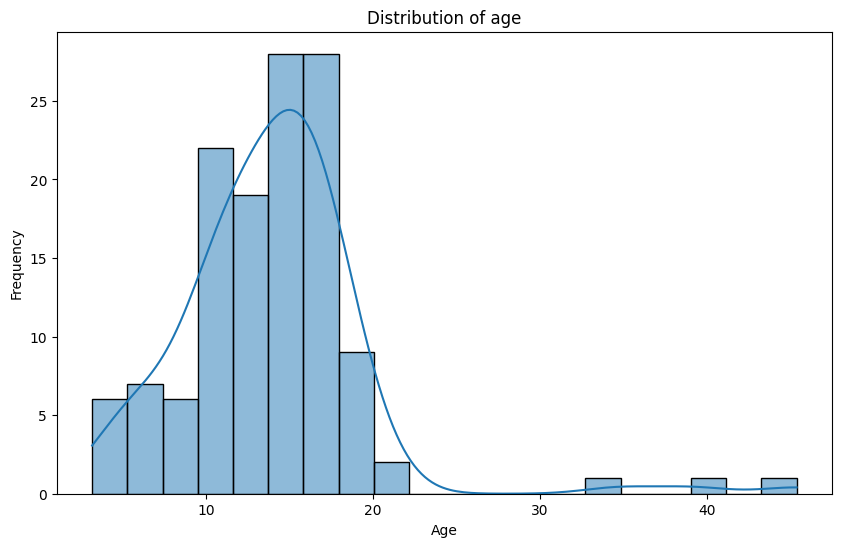

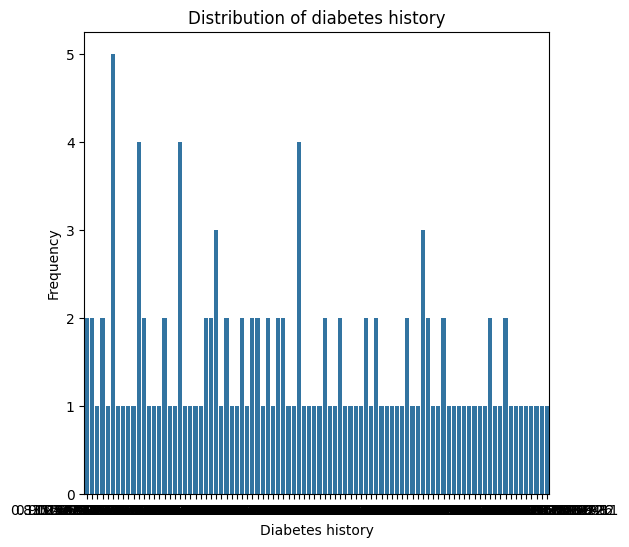

In [9]:

#plot distribution of Cluster_age
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'Cluster_age'
plt.figure(figsize=(10, 6))
sns.histplot(data=clinical_subset, x='Cluster_age', bins=20, kde=True)
plt.title('Distribution of age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of 'Cluster_diabete_history'
plt.figure(figsize=(6, 6))
sns.countplot(data=clinical_subset, x='Cluster_diabete_history')
plt.title('Distribution of diabetes history')
plt.xlabel('Diabetes history')
plt.ylabel('Frequency')
plt.show()



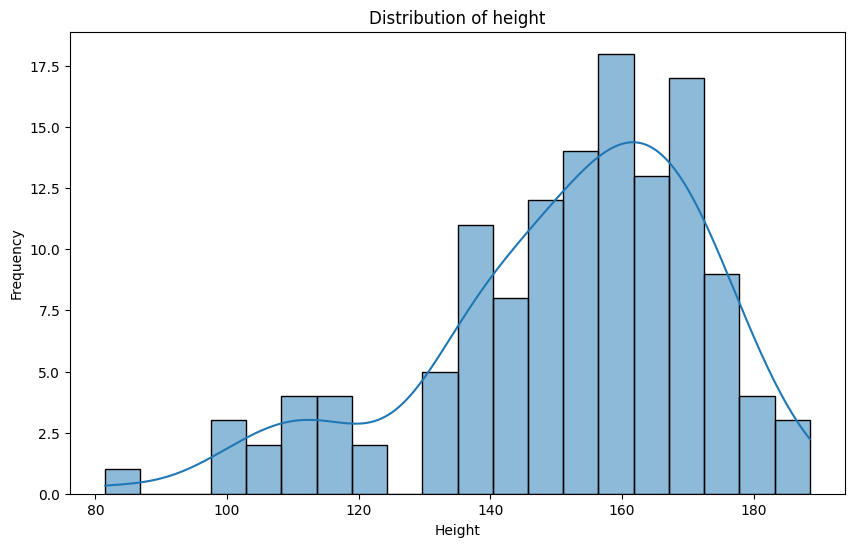

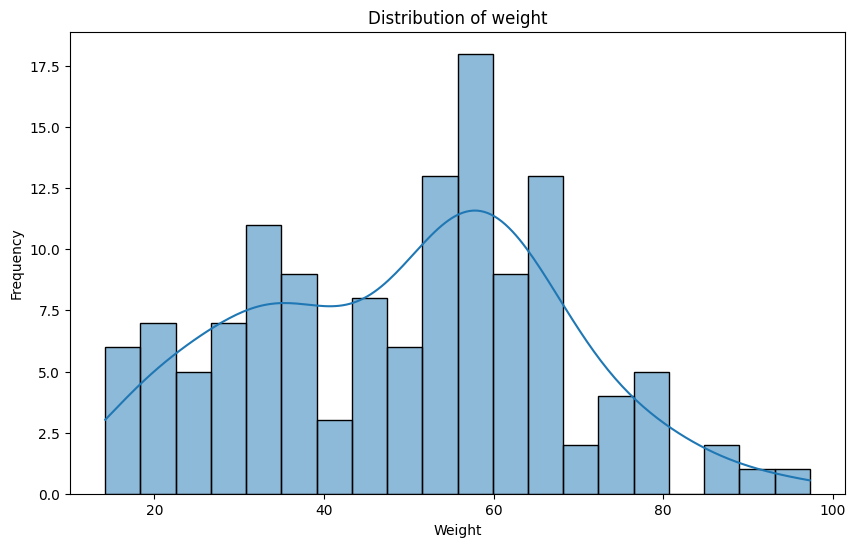

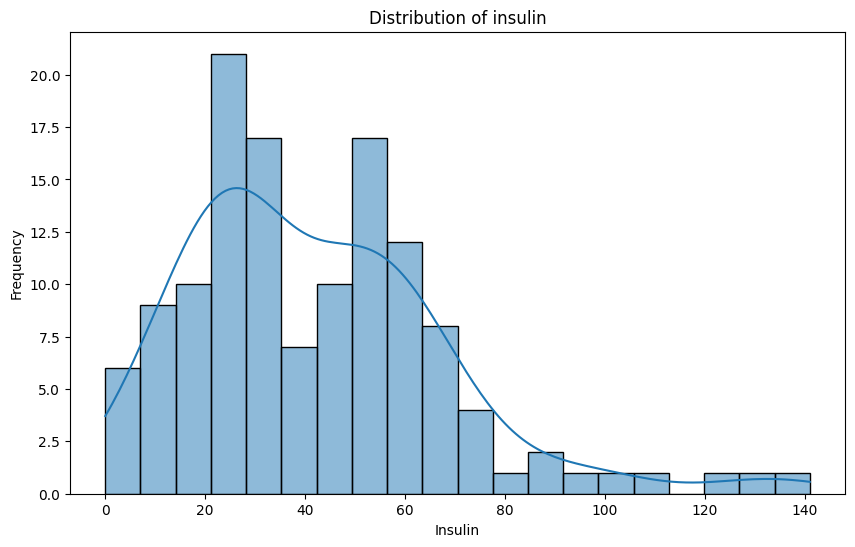

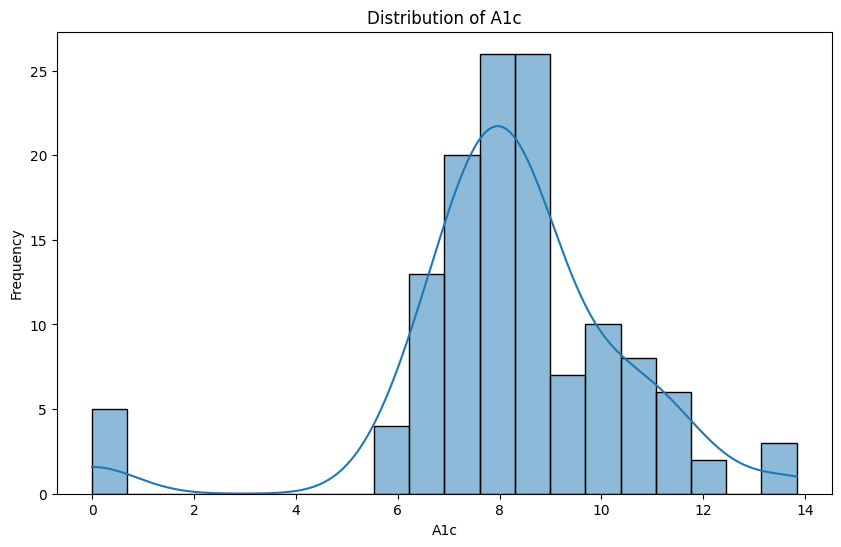

In [ ]:

#plot distribution of Cluster_height
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'Cluster_height'
plt.figure(figsize=(10, 6))
sns.histplot(data=clinical_subset, x='Cluster_height', bins=20, kde=True)
plt.title('Distribution of height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of 'Cluster_weight'
plt.figure(figsize=(10, 6))
sns.histplot(data=clinical_subset, x='Cluster_weight', bins=20, kde=True)
plt.title('Distribution of weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of 'Cluster_insulin'
plt.figure(figsize=(10, 6))
sns.histplot(data=clinical_subset, x='Cluster_insulin', bins=20, kde=True)
plt.title('Distribution of insulin')
plt.xlabel('Insulin')
plt.ylabel('Frequency')
plt.show()

#plot distribution of Cluster_A1c
plt.figure(figsize=(10, 6))
sns.histplot(data=clinical_subset, x='Cluster_A1c', bins=20, kde=True)
plt.title('Distribution of A1c')
plt.xlabel('A1c')
plt.ylabel('Frequency')
plt.show()



In [11]:

print(clinical_subset['Cluster_diabetes_siblings'].value_counts())

print(clinical_subset['Cluster_diabetes_father'].value_counts())

print(clinical_subset['Cluster_diabetes_mother'].value_counts())

print(clinical_subset['Cluster_diabetes_parents'].value_counts())
print(clinical_subset['Cluster_family_diabetes'].value_counts())
print(clinical_subset['Cluster_sex'].value_counts())

Cluster_diabetes_siblings
0    117
1     13
Name: count, dtype: int64
Cluster_diabetes_father
0    119
1     11
Name: count, dtype: int64
Cluster_diabetes_mother
0    122
1      8
Name: count, dtype: int64
Cluster_diabetes_parents
0    112
1     18
Name: count, dtype: int64
Cluster_family_diabetes
0    117
1     13
Name: count, dtype: int64
Cluster_sex
1    68
0    62
Name: count, dtype: int64


96GAD Qual
POS    66
neg    46
Name: count, dtype: int64
IA2 Qual
POS    58
neg    54
Name: count, dtype: int64
ZnT8 Qual
neg    69
POS    43
Name: count, dtype: int64


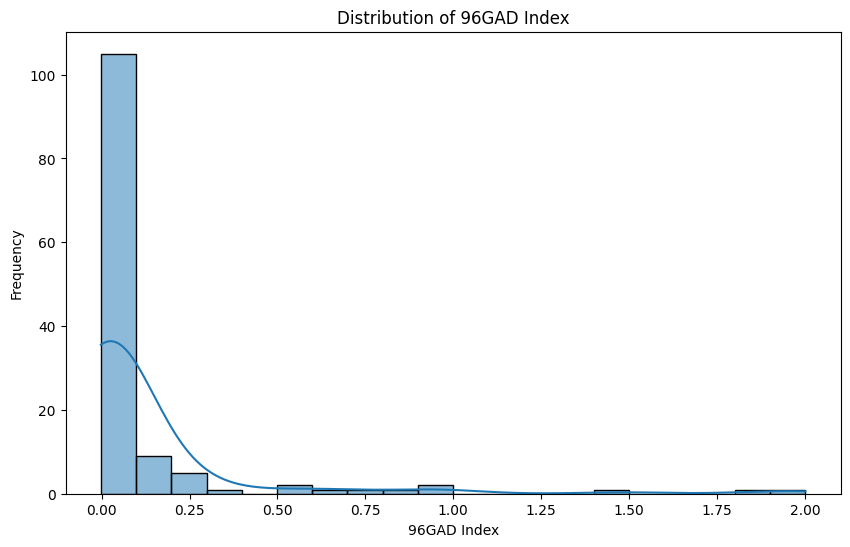

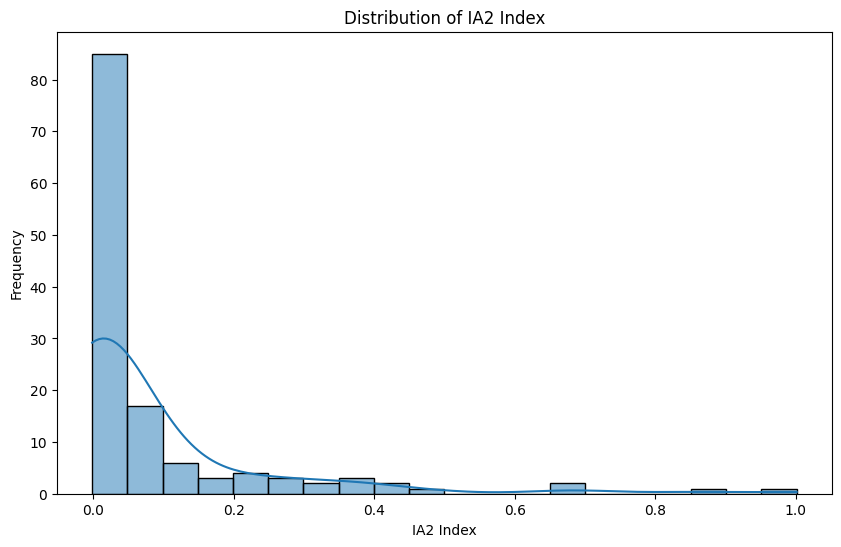

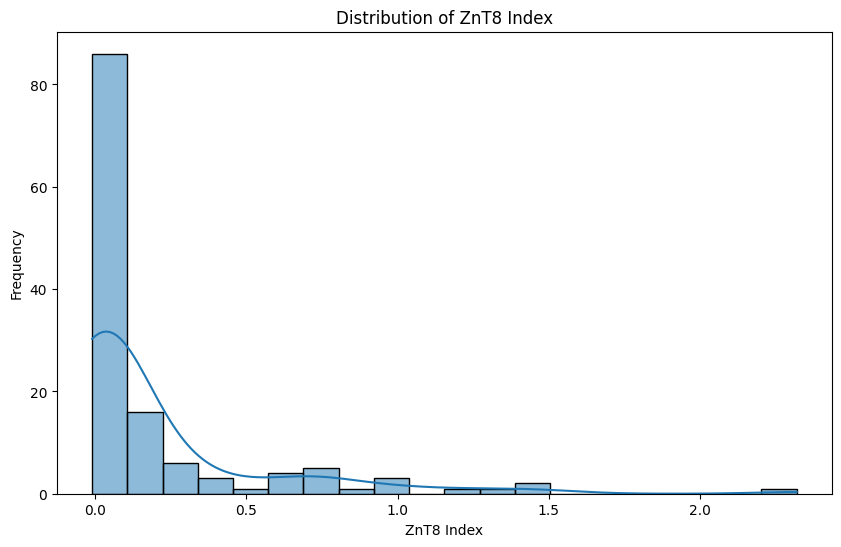

In [ ]:

print(antibody_subset['96GAD Qual'].value_counts())
print(antibody_subset['IA2 Qual'].value_counts())
print(antibody_subset['ZnT8 Qual'].value_counts())

#plot distribution of 96GAD Index
plt.figure(figsize=(10, 6))
sns.histplot(data=antibody_subset, x='96GAD Index', bins=20, kde=True)
plt.title('Distribution of 96GAD Index')
plt.xlabel('96GAD Index')
plt.ylabel('Frequency')
plt.show()

#plot distribution of IA2 Index
plt.figure(figsize=(10, 6))
sns.histplot(data=antibody_subset, x='IA2 Index', bins=20, kde=True)
plt.title('Distribution of IA2 Index')
plt.xlabel('IA2 Index')
plt.ylabel('Frequency')
plt.show()

#plot distribution of ZnT8 Index
plt.figure(figsize=(10, 6))
sns.histplot(data=antibody_subset, x='ZnT8 Index', bins=20, kde=True)
plt.title('Distribution of ZnT8 Index')
plt.xlabel('ZnT8 Index')
plt.ylabel('Frequency')
plt.show()


## Clustering analysis

We conducted clustering analysis on the 130 samples based on their clinical, genotype, antibody, and ancesty information. We followed the following steps:

* Preprocess: Standardization of the feature matrix.
* Dimensionality Reduction: Explore PCA and UMAP for dimension reduction and preliminary data cluster patterns.
* Cluster: Apply clustering algorithms (e.g., K-Means and Hierarchical).
* Visualize: Use PCA to visualize the clusters.
* Interpret: Analyze how the clusters relate to clinical and antibody data for insights.

Note that we first process the data with standardization to ensure that each feature contributes equally to the clustering process. 

### PCA Analysis (principal component analysis)

We then conduct PCA to see if we can reduce the dimensionality of the data. The result below shows the top 2 principle components can only explain 18% of the variance. The top 20 principle components can explain 71.5% of the variance.

Note that in our analysis, we identified 8 outliers in the PCA plot that were not consistent with the main clustering of samples. Considerint the context of the study, these samples most likely exhibited technical artifacts such as batch effects or genotyping errors, rather than representing true biological variation. Therefore, we excluded these outlier samples to ensure a more robust and reliable downstream analysis, while documenting this decision to maintain transparency in our data processing workflow.



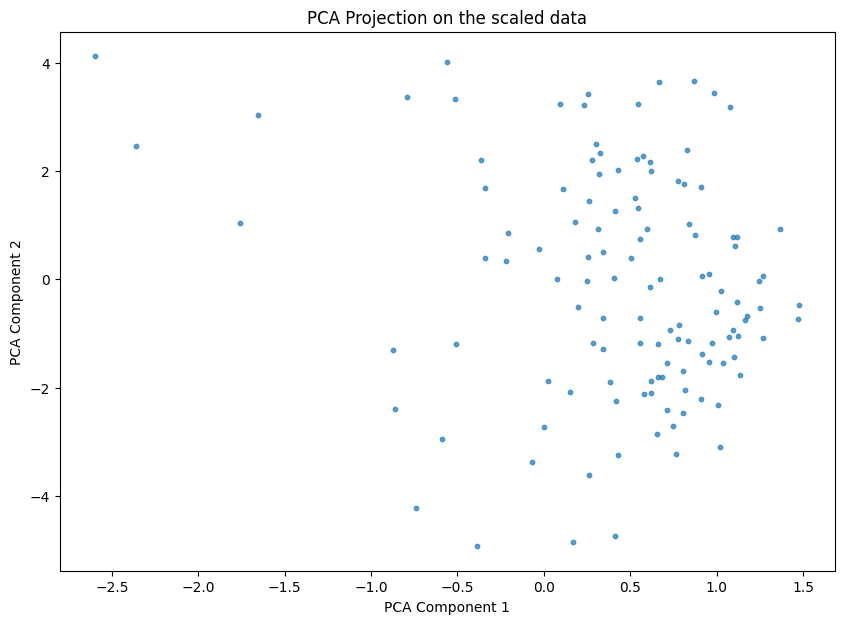

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings



# Separate clinical and genotype features
features = merged_data.drop(columns=['Subject'])  # Assuming 'Subject' rxist

# Handle missing values 
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

pd.DataFrame(features_scaled).to_csv('results/2025_scaled_features.csv', index=False)



#first plot PCA pc1 and pc2
pca = PCA(n_components=2)
pca_data_pc12 = pca.fit_transform(features_scaled)

#for clearer visulaization: remove outliers 
features_scaled = features_scaled[(pca_data_pc12[:, 0] > -3) & (pca_data_pc12[:, 1] < 5)]

pca_data_pc12 = pca_data_pc12[(pca_data_pc12[:, 0] > -3) & (pca_data_pc12[:, 1] < 5)]


# Plot the PCA-transformed data
plt.figure(figsize=(10, 7))
plt.scatter(pca_data_pc12[:, 0], pca_data_pc12[:, 1], s=10, alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection on the scaled data')
plt.show()


#save the features_scaled to /results/cluster_Oct_features.csv
pd.DataFrame(features_scaled).to_csv('results/2025_scaled_features_outliers.csv', index=False)



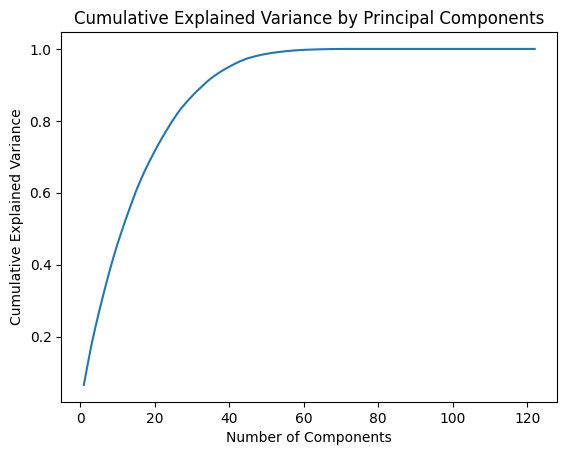

Cumulative explained variance by top 20 components:
[0.066, 0.12, 0.175, 0.221, 0.265, 0.307, 0.347, 0.386, 0.422, 0.456, 0.488, 0.519, 0.548, 0.576, 0.604, 0.629, 0.653, 0.675, 0.695, 0.715]
Number of components required to explain 80% of the variance: 25
Number of components required to explain 90% of the variance: 34


In [ ]:


from sklearn.decomposition import PCA
import seaborn as sns

# calculate the PCA 

# Apply PCA 
pca = PCA()
pca.fit(features_scaled)  # Assuming `features_scaled`

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative proportion of variance explained by each component
cumulative_variance_ratio = explained_variance_ratio.cumsum()
sns.lineplot(x=range(1, len(cumulative_variance_ratio) + 1), y=cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.show()

print("Cumulative explained variance by top 20 components:")
print([round(var, 3) for var in cumulative_variance_ratio[:20]])

n_components = (cumulative_variance_ratio < 0.8).sum() + 1  
print(f"Number of components required to explain 80% of the variance: {n_components}")

n_components = (cumulative_variance_ratio < 0.9).sum() + 1  
print(f"Number of components required to explain 90% of the variance: {n_components}")




### UMAP Analysis (with and without PCA)


We then applied UMAP to the processed data directly to see if we can reduce the dimensionality of the data. However, we did not find any clear clustering pattern with UMAP projections. Specifically, UMAP is a popular non-linear dimension reduction method to reduce data dimensions for a density based clustering algorithm to make progress on. In our practise we manually tuned parameter values of UMAP to explore potential patterns for treatment assignments. For example, we prefer a larger n_neighbors value since small small values will focus more on very local structure and are more prone to producing fine grained cluster structures not fit for treatment assignments. We tried different vaues of n_neighborhoods starting from default 15 to 30. Second it is beneficial to set min_dist to a very low value since we actually want to pack points together densely to making cleaner separations between treatment assignment clusters. We tried different values of min_dist starting from 0.1 to 0.01. We also tried different values of n_components starting from 2 to 3. However, we did not find any clear clustering pattern with UMAP projections. An example of UMAP results is shown below with n_neighbors=15, minimum distance 0.1 and n_componenets 2.




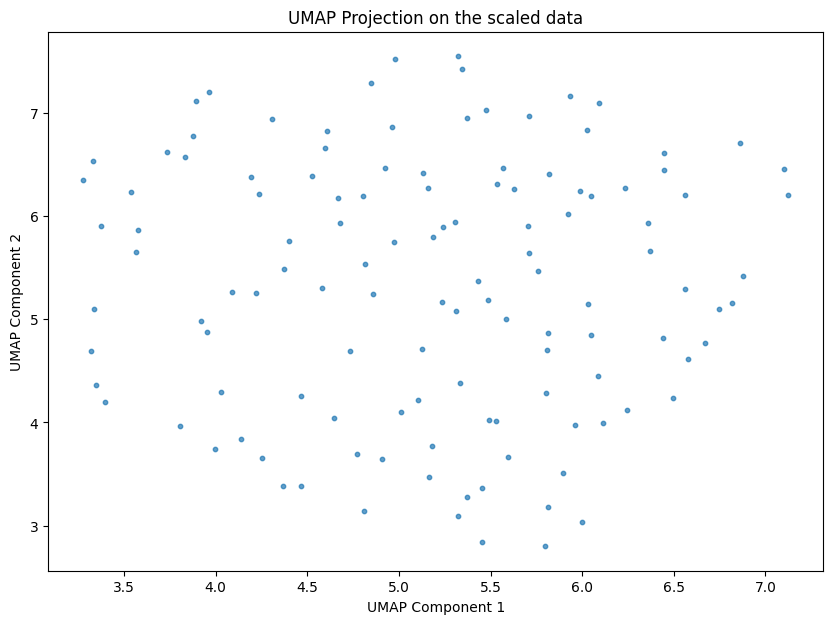

In [17]:
#conduct UMAP on the scaled features
from umap import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Transform the data with UMAP
features_umap = umap.fit_transform(features_scaled)

# Plot UMAP result
plt.figure(figsize=(10, 7))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=10, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection on the scaled data')
plt.show()



Next, we applied UMAP to the top 36 principle components of the PCA analysis. Note that the top 36 principle components can explain 90% of the variance. However, we did not find any clear clustering pattern with UMAP projections under various settings. An example of UMAP results is shown below with n_neighbors=15, minimum distance 0.1 and n_componenets 2.


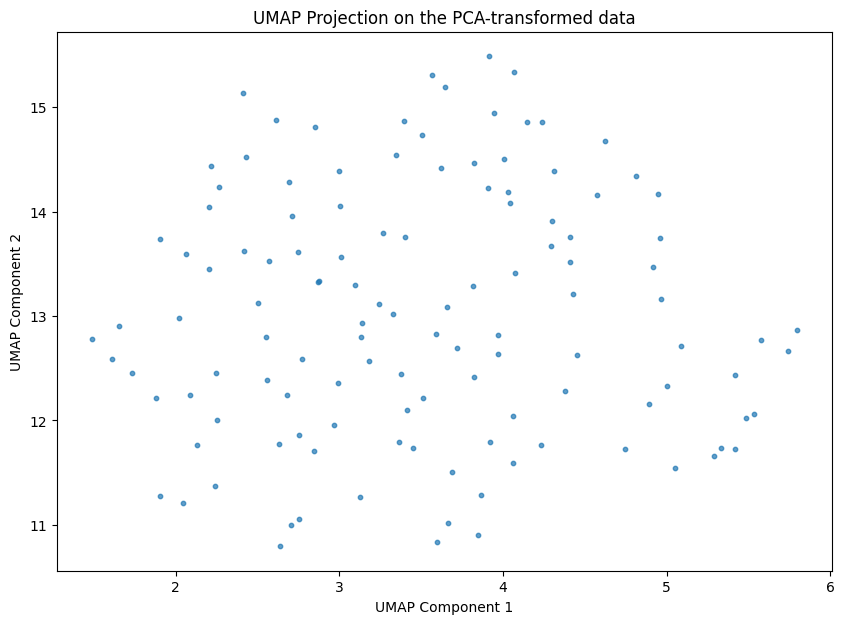

In [18]:
#apply UMAP to the top 34 PC components

# Apply PCA to the scaled features
pca = PCA(n_components=36)
features_pca = pca.fit_transform(features_scaled)

# Transform the PCA features with UMAP
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
features_pca_umap = umap.fit_transform(features_pca)

# Plot UMAP result
plt.figure(figsize=(10, 7))
plt.scatter(features_pca_umap[:, 0], features_pca_umap[:, 1], s=10, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection on the PCA-transformed data')
plt.show()


### K-means clustering

K-Means Clustering: This is one of the most widely used clustering algorithms. It’s fast and effective for datasets with spherical clusters. We use Silhouette Score to evaluate the quality of clusters and choose the optimal number of clusters.



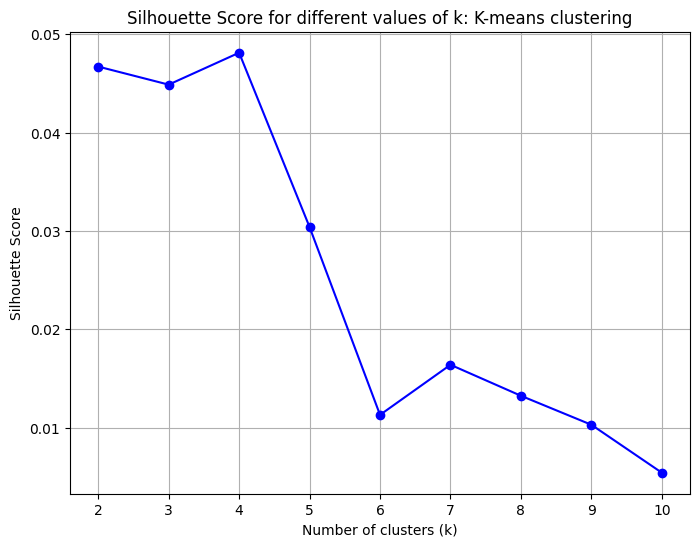

In [ ]:
# Range of possible values for k (number of clusters)
K = range(2, 11)  

# List to store the silhouette scores for each k
silhouette_scores = []

# Loop over different values of k
for k in K:
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)  # Assuming `features_scaled` 
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    
    # Store the silhouette score
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bo-', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different values of k: K-means clustering')
plt.grid(True)
plt.show()

Apparently, the otpimal number of clusters is 4. We then visualize the clustering results using PCA.

Cluster
2    65
3    28
0    18
1    11
Name: count, dtype: int64


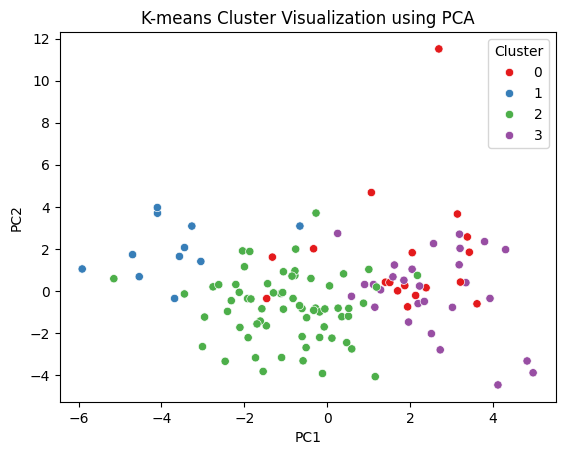

In [34]:
from sklearn.decomposition import PCA
import seaborn as sns

# Evaluate the silhouette score for a given k
optimal_k = 4  #
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(features_scaled)

cluster_labels = cluster_labels_kmeans

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

# Create a DataFrame for visualization
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = cluster_labels
#print cluster_labels counts
print(reduced_df['Cluster'].value_counts())


# Plot the clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='Set1')
plt.title('K-means Cluster Visualization using PCA')
plt.show()


The result shows that:

* the first two principal components capture enough of the structure in the data to make the clusters distinguishable.

* the 4-clusters can be merged into two meta-clusters since the PC1 and PC2 visuaization strongly suggest that cluster 0 and 3 are very close to each other, and same for cluster 1 and 2. 


We then create two meta-clusters by merging cluster 0 and 3 into a single meta-cluster, and same for cluster 1 and 2. We then interpret and analyze how these two clusters from K-Means clustering relate to clinical, genotype and antibody data.

In [35]:
#merge cluster_labels 0 and 3 into one cluster, 1 and 2 into another cluster
#replace 3 to 0, replace 2 to 1
cluster_labels = [0 if x == 3 else x for x in cluster_labels]
cluster_labels = [1 if x == 2 else x for x in cluster_labels]

#table of cluster_labels
print("2-cluster structure:")
print(pd.Series(cluster_labels).value_counts())

2-cluster structure:
1    76
0    46
Name: count, dtype: int64


In [ ]:
import pandas as pd

features_columns = features.columns  


# Create features_genotype 
features_genotype = pd.DataFrame(features_scaled[:, :123], columns=features_columns[:123])
features_genotype['Cluster'] = cluster_labels  # Add the cluster labels


# Create features_clinical
features_clinical = pd.DataFrame(features_scaled[:, 123:135], columns=features_columns[123:135])
features_clinical['Cluster'] = cluster_labels  # Add the cluster labels


# Create features_antibody 
features_antibody = pd.DataFrame(features_scaled[:, 135:141], columns=features_columns[135:141])
features_antibody['Cluster'] = cluster_labels  # Add the cluster labels


features_ancestry = pd.DataFrame(features_scaled[:, 141:], columns=features_columns[141:])
features_ancestry['Cluster'] = cluster_labels  # Add the cluster labels


For clinical data, we first show summary statistics (e.g., mean) for features within each cluster. 



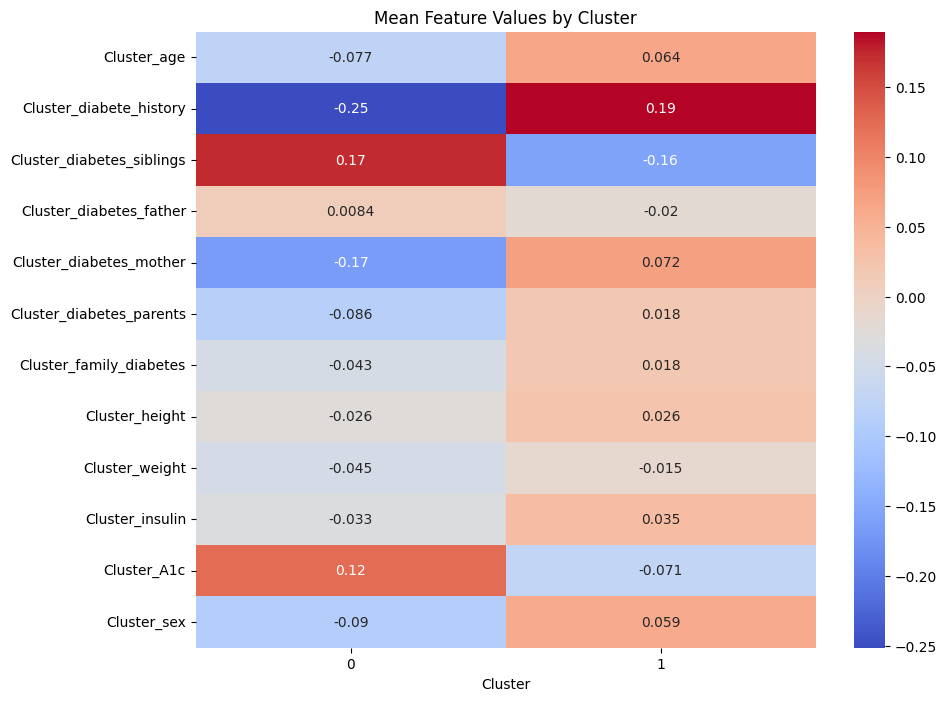

In [ ]:
import seaborn as sns

cluster_summary = features_clinical.groupby('Cluster').mean()

# Create a heatmap of mean feature values for each cluster
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True)
plt.title('Mean Feature Values by Cluster')
plt.show()


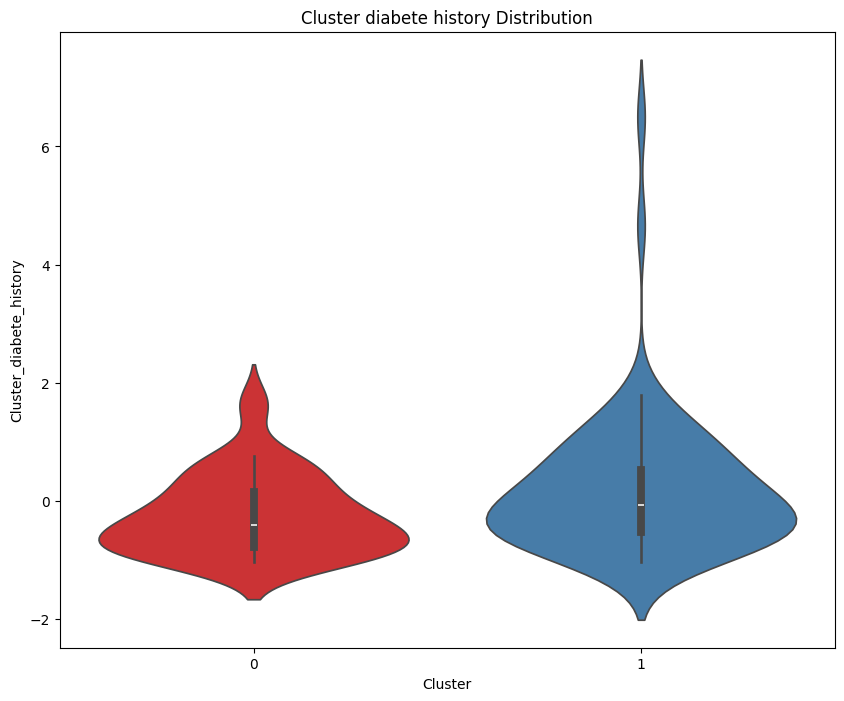

Cluster_diabetes_siblings table:
Cluster_diabetes_siblings  False  True 
Cluster                                
0                             39      7
1                             72      4


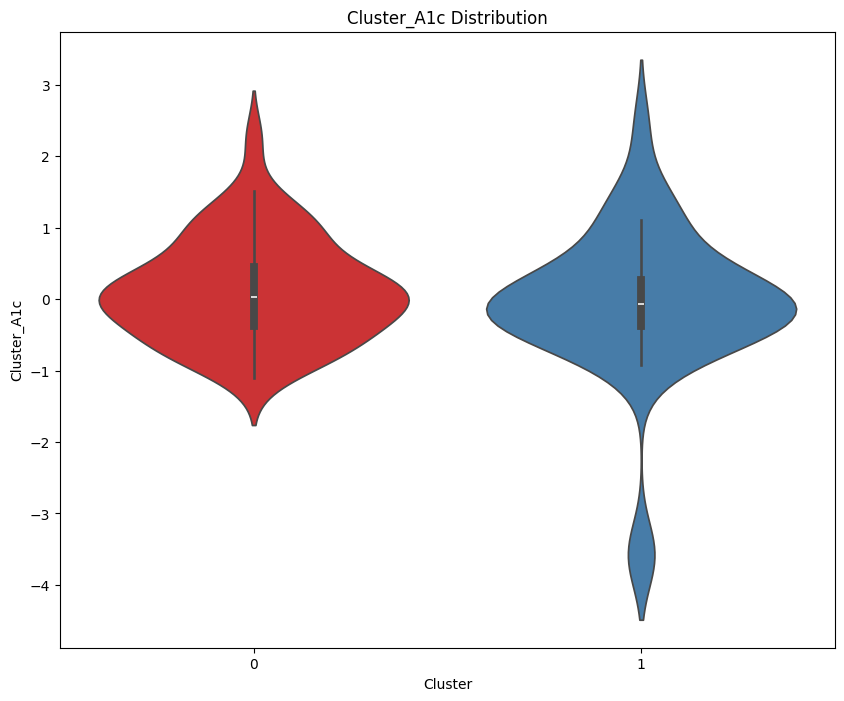

In [ ]:
#we then plot the violin plot for the cluster_sex and cluster_weight features
# Violin plot


plt.figure(figsize=(10, 8))
sns.violinplot(x='Cluster', y='Cluster_diabete_history', data=features_clinical, palette='Set1')
plt.title('Cluster diabete history Distribution')
plt.show()


print("Cluster_diabetes_siblings table:")
print(pd.crosstab(features_clinical['Cluster'], features_clinical['Cluster_diabetes_siblings']>0))

      
plt.figure(figsize=(10, 8))
sns.violinplot(x='Cluster', y='Cluster_A1c', data=features_clinical, palette='Set1')
plt.title('Cluster_A1c Distribution')
plt.show()


We then examine the statistical significance of each feature in the clinical data between clusters. We use ANOVA tests to compare the means of each feature between clusters. The p-values are shown below. Note that the p-values are not corrected for multiple testing.


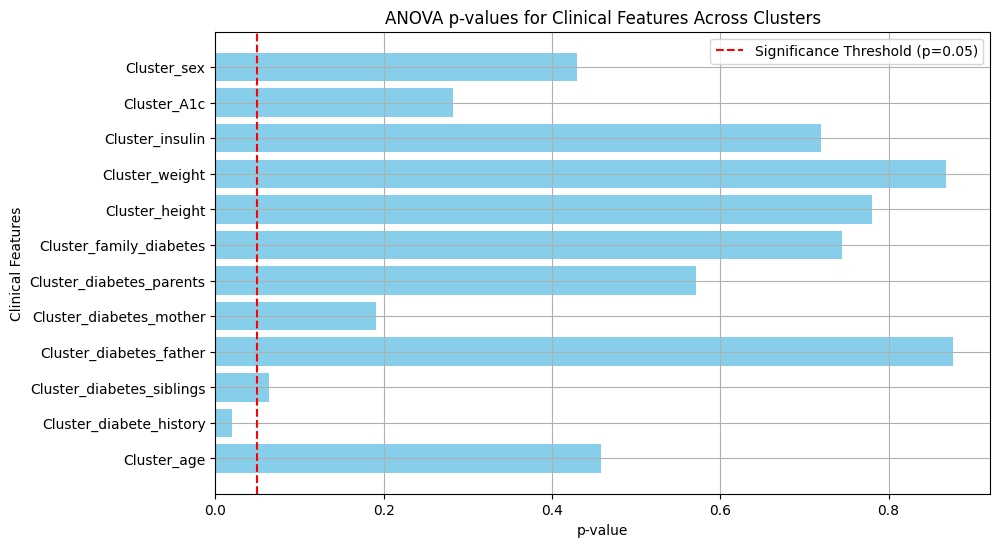

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels = features_clinical['Cluster']

# List to store p-values
p_values = []

# Perform ANOVA for each feature in the clinical data
for column in clinical_features.columns:
    # Perform ANOVA across clusters for this feature
    groups = [clinical_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values.append(p_value)

p_values_df = pd.DataFrame({'Feature': clinical_features.columns, 'p-value': p_values})

# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Clinical Features')
plt.title('ANOVA p-values for Clinical Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()


Note that the association between clinical features and the cluster membership is only statistically significant for diabete_history, specifically, the cluster 1 has a higher average diabete_history than cluster 0.


Next, we examine the statistical significance of each feature in the genotype data between clusters. We use ANOVA tests to compare the means of each feature between clusters. The p-values are shown below. Note that the p-values are corrected for multiple testing with Bonferroni correction.

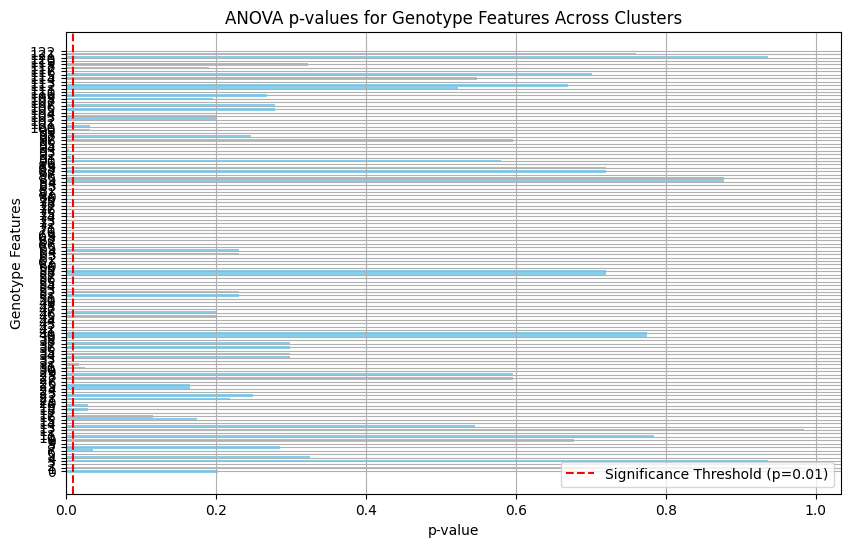

Genotype features with p-value < 0.05 after Bonferroni correction:
72    72
73    73
81    81
82    82
Name: Feature, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels = features_genotype['Cluster']

n_features = len(genotype_features.columns)

p_values_genotype = []

# Perform ANOVA for each feature in the genotype data
for column in genotype_features.columns:
    # Perform ANOVA across clusters for this feature
    groups = [genotype_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_genotype.append(p_value)

p_values_genotype_df = pd.DataFrame({'Feature': genotype_features.columns, 'p-value': p_values_genotype})

# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_genotype_df['Feature'], p_values_genotype_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Genotype Features')
plt.title('ANOVA p-values for Genotype Features Across Clusters')
plt.axvline(x=0.01, color='red', linestyle='--', label='Significance Threshold (p=0.01)')
plt.legend()
plt.grid(True)
plt.show()

significant_genotype_features = p_values_genotype_df[p_values_genotype_df['p-value'] < 0.05/n_features]

print("Genotype features with p-value < 0.05 after Bonferroni correction:")
print(significant_genotype_features['Feature'])



As a result, we found these SNPs corresponds to the features with the most significant p-values in the t-tests:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

significant_snps = significant_genotype_features['SNP'].drop_duplicates()

# Print the unique SNPs corresponding to significant genotype features
print("Significant SNPs corresponding to p-value < 0.01:")
print(significant_snps)

#now print the corresponding rows in bim
print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.01:
72    25
81    28
Name: SNP, dtype: int64
   chrom        snp   cm       pos a0 a1   i
24     6  rs2395228  0.0  32655446  C  A  24
27     6  rs1049124  0.0  32659936  A  G  27


We found two SNPs in the MHC region are significantly associated with the K-means clustering patterns. The two SNPs are rs2395228 and rs1049124. 

It is important to note that this results confirmed that our finding in the previous analysis last year can be replicated:

* rs2395228 is consistent with the previous clustering analysis in the first batch of samples. We found exactly this snp to drive the clustering in the first batch of samples with both Kmeans and Hierarchical clustering.

* rs1049124 is consistent with the previous clustering analysis in the first batch of samples. We found exactly this snp to drive the clustering in the first batch of samples with Hierarchical clustering, but not found it with Kmeans clustering.
 
Next, we explore the relationship between the clusters and the antibody levels.  We first show  the p-values from ANOVA test for each feature in the antibody profiles between clusters.


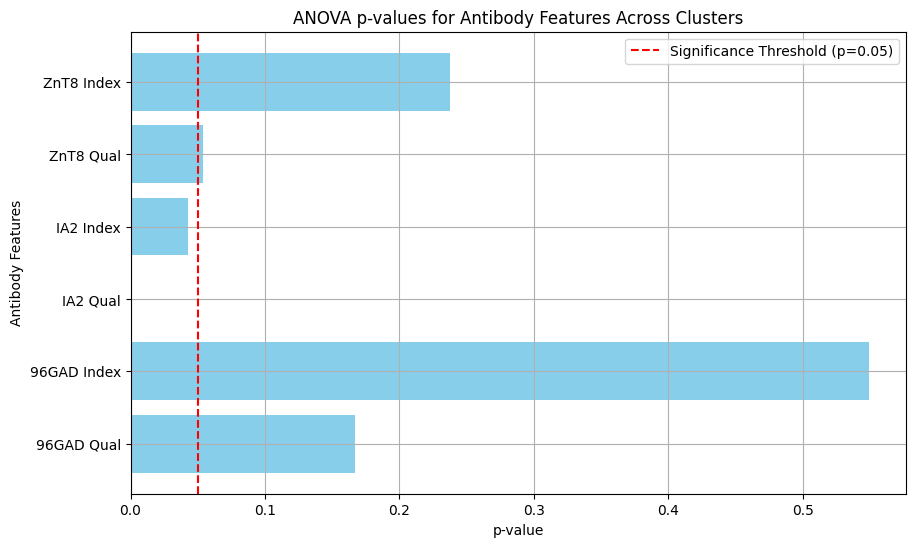

Antibody features with p-value < 0.05:
2     IA2 Qual
3    IA2 Index
Name: Feature, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels = features_antibody['Cluster']

p_values_antibody = []

for column in antibody_features.columns:
    groups = [antibody_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_antibody.append(p_value)

p_values_antibody_df = pd.DataFrame({'Feature': antibody_features.columns, 'p-value': p_values_antibody})

# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_antibody_df['Feature'], p_values_antibody_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Antibody Features')
plt.title('ANOVA p-values for Antibody Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()

significant_antibody_features = p_values_antibody_df[p_values_antibody_df['p-value'] < 0.05]

print("Antibody features with p-value < 0.05:")
print(significant_antibody_features['Feature'])


Note that the associations between the clusters and the antibody levels are significant only for IA2.

We then plot the boxplot of the antibody features for each cluster.

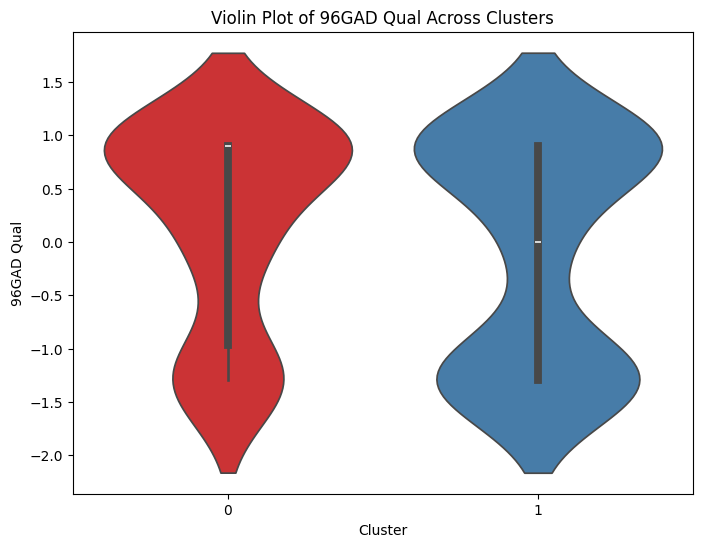

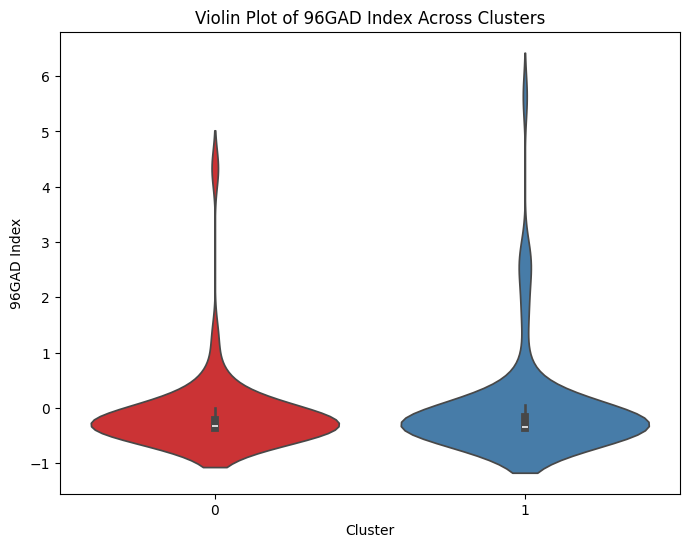

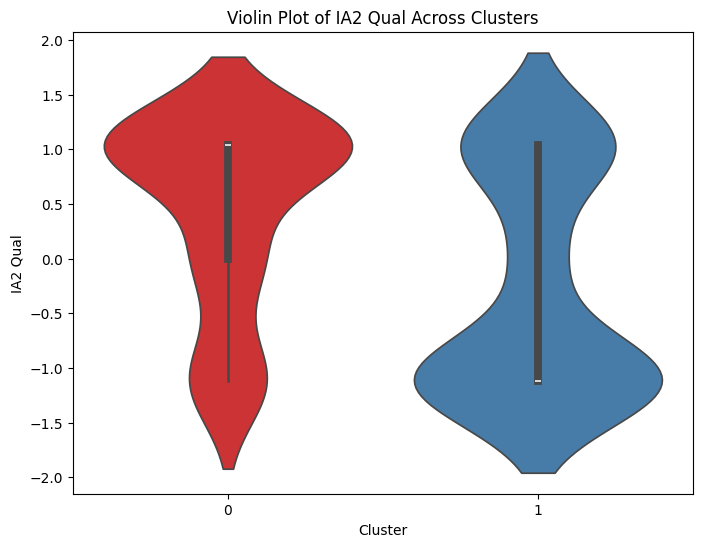

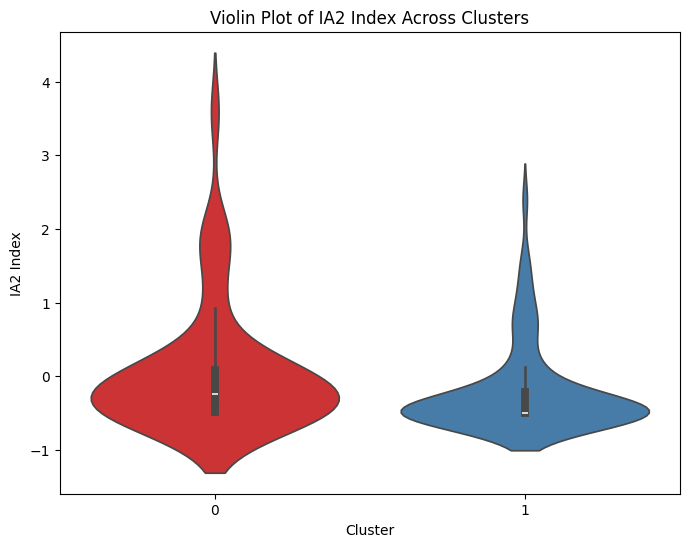

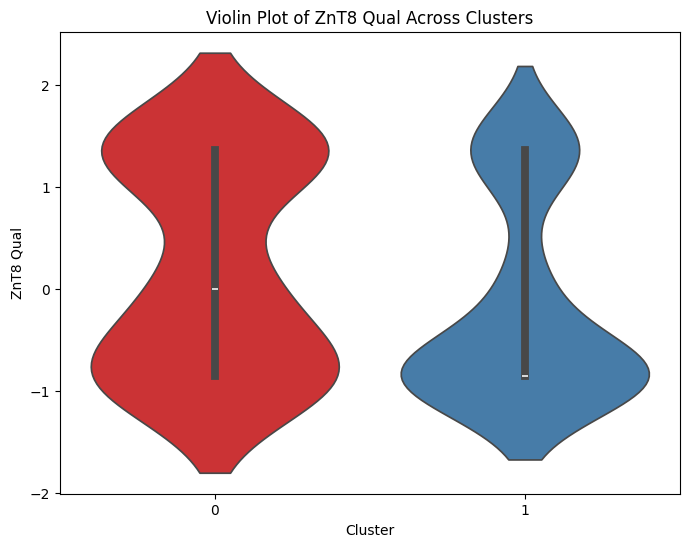

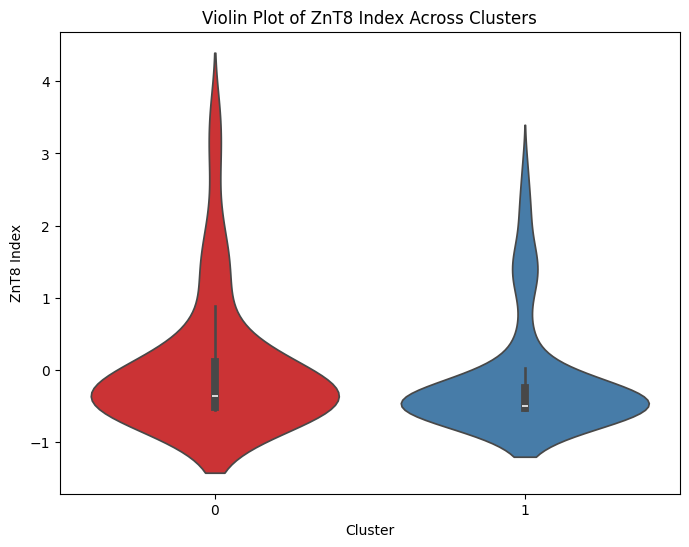

In [ ]:
#plot the violin plot of each antibody features across clusters
import warnings
warnings.filterwarnings("ignore")
for column in antibody_features.columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Cluster', y=column, data=features_antibody, palette='Set1')
    plt.title(f'Violin Plot of {column} Across Clusters')
    plt.show()
    



Finally, we examine the relationship between the clusters and the ancestry information. We first show the p-values from ANOVA test for each feature in the ancestry profiles between clusters.

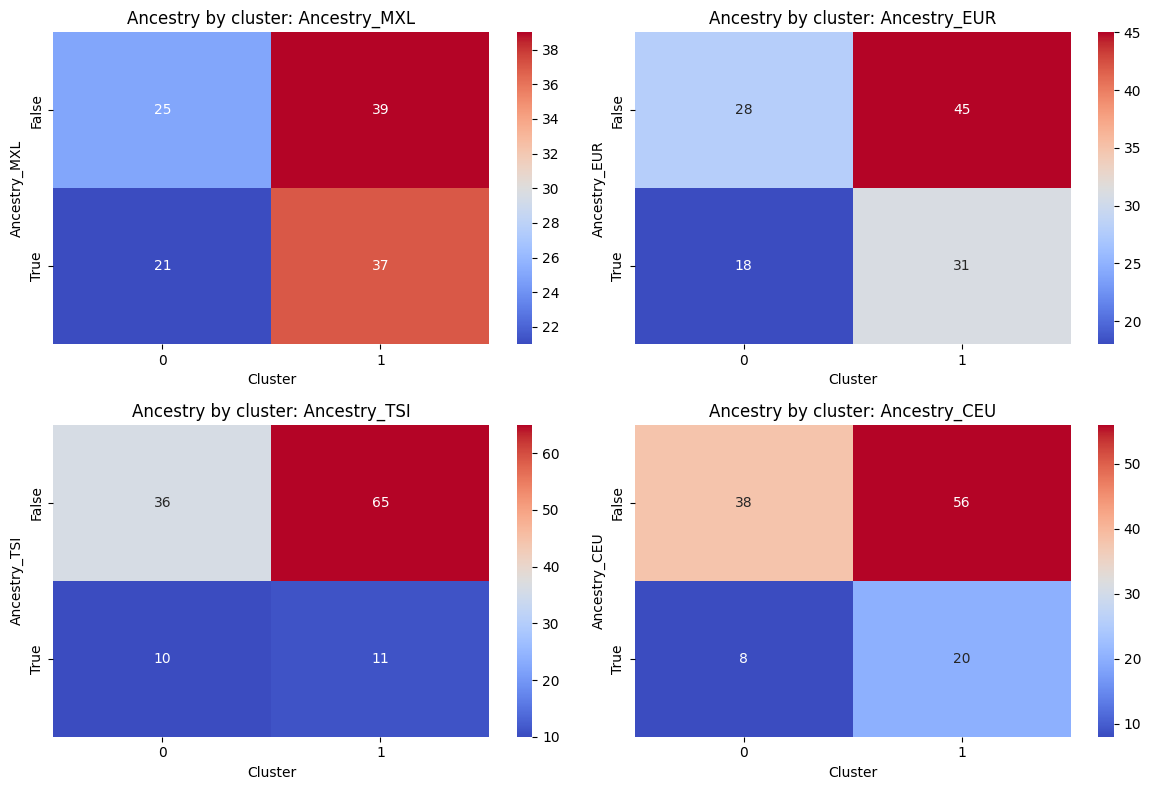


Chi-square Test Results for European ancestry versus clustering labels:
p-value: 1.000


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

ancestry_features = features_ancestry.drop(columns=['Cluster'])
cluster_labels = features_ancestry['Cluster']

# Create a contrast table for each ancestry feature
contrast_tables = []
for column in ancestry_features.columns:
    contrast_table = pd.crosstab(ancestry_features[column]>0, cluster_labels)
    contrast_tables.append(contrast_table)


    
# Plot the contrast tables
plt.figure(figsize=(12, 8))
for i, table in enumerate(contrast_tables):
    #feature name of i-th feature
    feature_name = ancestry_features.columns[i]
    plt.subplot(2, 2, i + 1)
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Ancestry by cluster: {feature_name}')
plt.tight_layout()
plt.show()

# Perform a chi-square test for the contrast table of Ancestry_EUR
contrast_table = contrast_tables[1]
chi2, p_value, dof, expected = chi2_contingency(contrast_table)

print("\nChi-square Test Results for European ancestry versus clustering labels:")
print(f"p-value: {p_value:.3f}")


In conlusion, the associations between the clusters and the ancestry information are not statistically significant.

### Hierarchical clustering

We then try the hierarchical clustering and find the optimal number of clusters with the dendrogram.

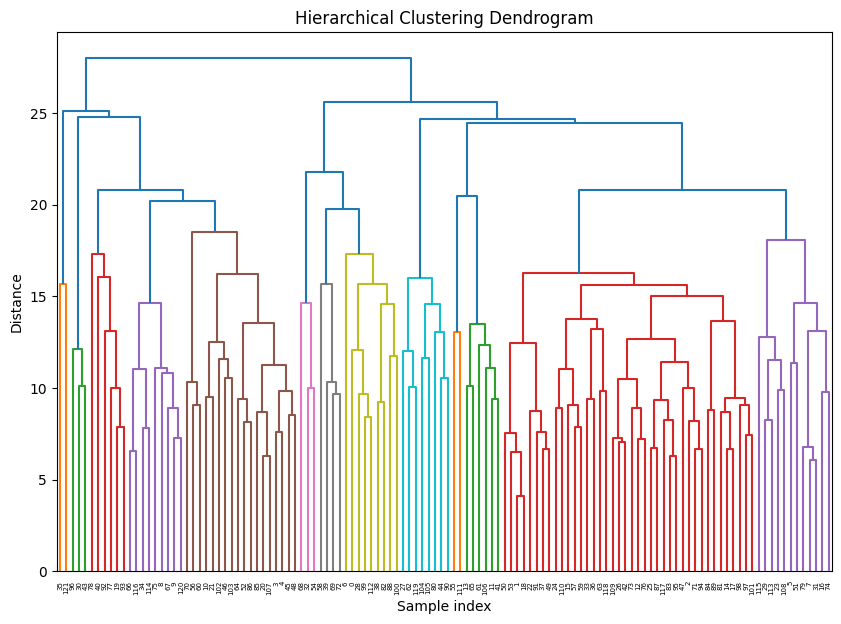

The optimal number of clusters is: 2


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Perform hierarchical clustering using AgglomerativeClustering
# Compute the linkage matrix for visualization in dendrogram
linkage_matrix = linkage(features_scaled, method='ward')

# Step 2: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Step 3: Compute Agglomerative Clustering with different numbers of clusters
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative_clustering.fit_predict(features_scaled)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)



# Step 4: Identify the optimal number of clusters (maximum silhouette score)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: 2")

optimal_n_clusters = 2

We then visualize the HC clustering results using PCA to see if the clusters are distinguishable with respect to PCA. The result below shows the HC clustering membership versus the first two principle components of the PCA analysis. We also present the cross-table of HC clustering membership versus the K-means clustering membership. The result shows that these two clustering memberships captured different patterns in the data.

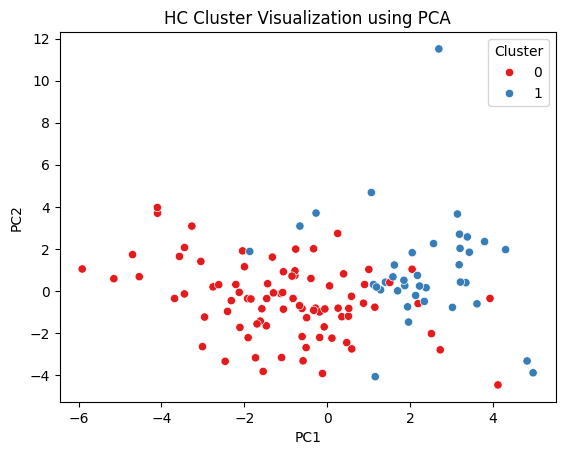

Contingency Table of K-Means and HC Clusters:
HC Clusters        0   1
K-Means Clusters        
0                  4  14
1                 10   1
2                 60   5
3                 10  18


In [ ]:

# Perform Agglomerative Clustering with the optimal number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters)
cluster_labels_hc = agglomerative_clustering.fit_predict(features_scaled)



# Create a DataFrame for visualization
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = cluster_labels_hc

# Plot the clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='Set1')
plt.title('HC Cluster Visualization using PCA')
plt.show()

comparison_df = pd.DataFrame({'K-Means Clusters': cluster_labels_kmeans, 'HC Clusters': cluster_labels_hc})
print("Contingency Table of K-Means and HC Clusters:")
print(pd.crosstab(comparison_df['K-Means Clusters'], comparison_df['HC Clusters']))



We then explore the relationship between the HC clusters and the clinical, genotype, and antibody data.

The associations between the clusters and the clinical features are not significant as shown below.

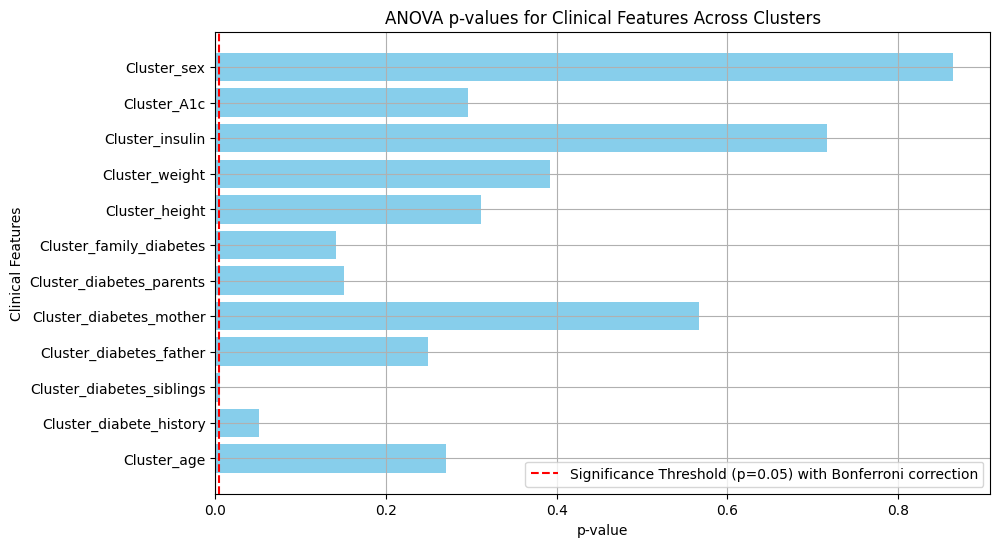

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc


results = []

for column in clinical_features.columns:
    unique_values = clinical_features[column].nunique()
    
    if unique_values == 2:  # Binary feature
        contingency_table = pd.crosstab(cluster_labels, clinical_features[column])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        results.append({'Feature': column, 'p-value': p_value, 'Test': 'Chi-square'})
    else:  # Continuous feature
        # Perform ANOVA across clusters
        groups = [clinical_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
        _, p_value = f_oneway(*groups)
        results.append({'Feature': column, 'p-value': p_value, 'Test': 'ANOVA'})

p_values_df = pd.DataFrame(results)


# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Clinical Features')
plt.title('ANOVA p-values for Clinical Features Across Clusters')
plt.axvline(x=0.05/12, color='red', linestyle='--', label='Significance Threshold (p=0.05) with Bonferroni correction')
plt.legend()
plt.grid(True)
plt.show()






Furthermore, we explore the relationship between the HC clusters and the genotype data.


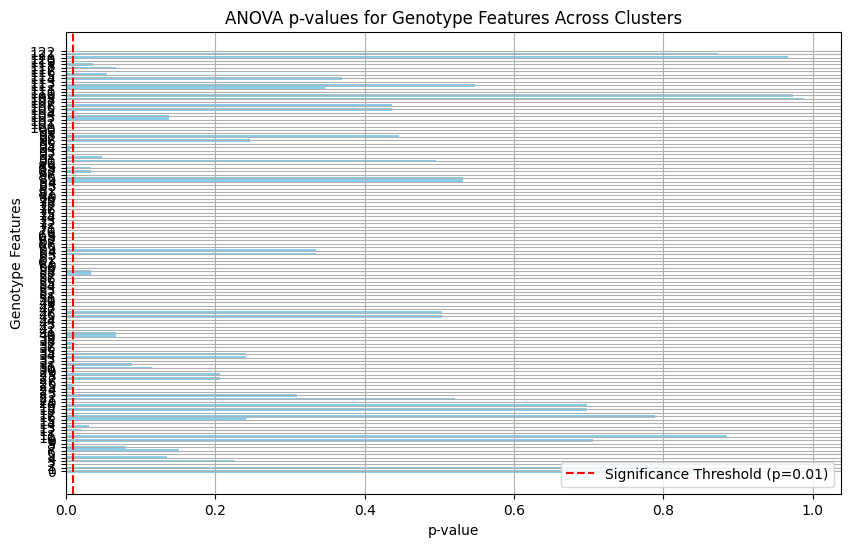

Genotype features with p-value < 0.05 after Bonferroni correction:
72    72
73    73
81    81
82    82
Name: Feature, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

genotype_features = features_genotype.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

n_genotypes = len(genotype_features.columns)
p_values_genotype = []

for column in genotype_features.columns:
    groups = [genotype_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_genotype.append(p_value)

p_values_genotype_df = pd.DataFrame({'Feature': genotype_features.columns, 'p-value': p_values_genotype})

plt.figure(figsize=(10, 6))
plt.barh(p_values_genotype_df['Feature'], p_values_genotype_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Genotype Features')
plt.title('ANOVA p-values for Genotype Features Across Clusters')
plt.axvline(x=0.01, color='red', linestyle='--', label='Significance Threshold (p=0.01)')
plt.legend()
plt.grid(True)
plt.show()

significant_genotype_features = p_values_genotype_df[p_values_genotype_df['p-value'] < 0.05/n_genotypes]

print("Genotype features with p-value < 0.05 after Bonferroni correction:")
print(significant_genotype_features['Feature'])


We then look into the SNPs that are associated with the clusters identified in the HC clustering analysis.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

# Drop duplicate SNPs 
significant_snps = significant_genotype_features['SNP'].drop_duplicates()

print("Significant SNPs corresponding to p-value < 0.05 after bonreffoni correction:")
print(significant_snps)
print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.05 after bonreffoni correction:
72    25
81    28
Name: SNP, dtype: int64
   chrom        snp   cm       pos a0 a1   i
24     6  rs2395228  0.0  32655446  C  A  24
27     6  rs1049124  0.0  32659936  A  G  27


Apparently, all those significant SNPs are exactly the same as the SNPs we found in the K-means clustering. This implies that the k-means clustering and HC results are consistent with each other in terms of the genotype profiles that drive the clustering.

Again, we explore the relationship between the HC clusters and the antibody levels. We found that only IA2 are significantly associated with HC custerings.

       Feature   p-value
0   96GAD Qual  0.150457
1  96GAD Index  0.707683
2     IA2 Qual  0.000020
3    IA2 Index  0.009576
4    ZnT8 Qual  0.126891
5   ZnT8 Index  0.712475


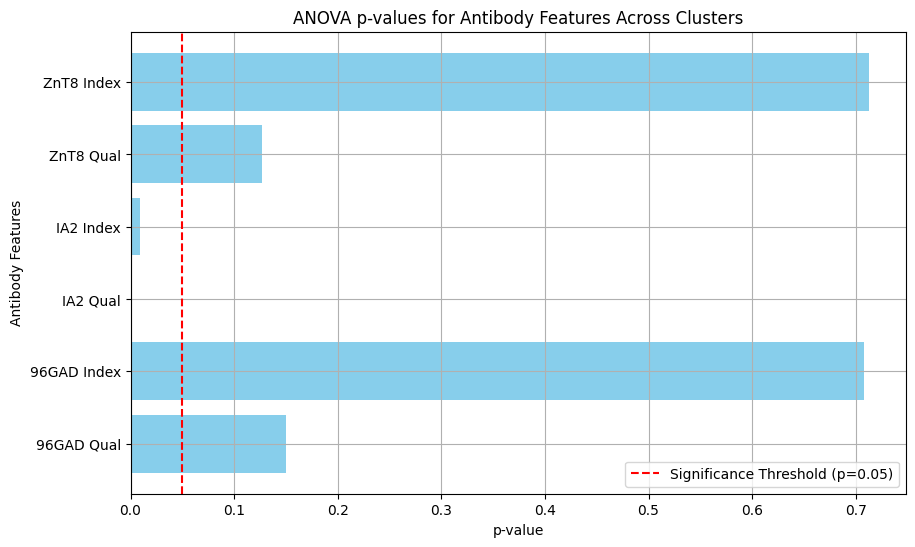

Antibody features with p-value < 0.05:
2    IA2 Qual
Name: Feature, dtype: object


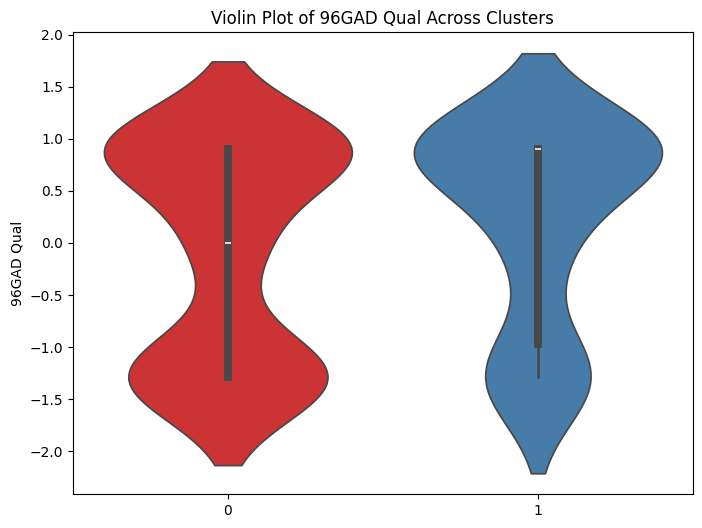

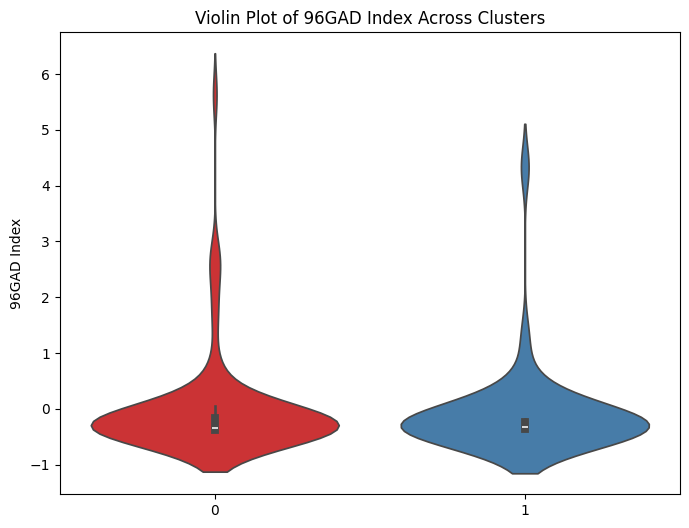

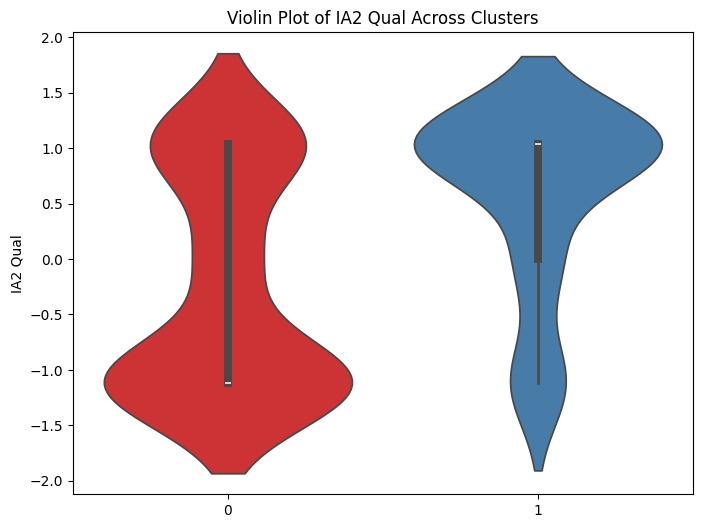

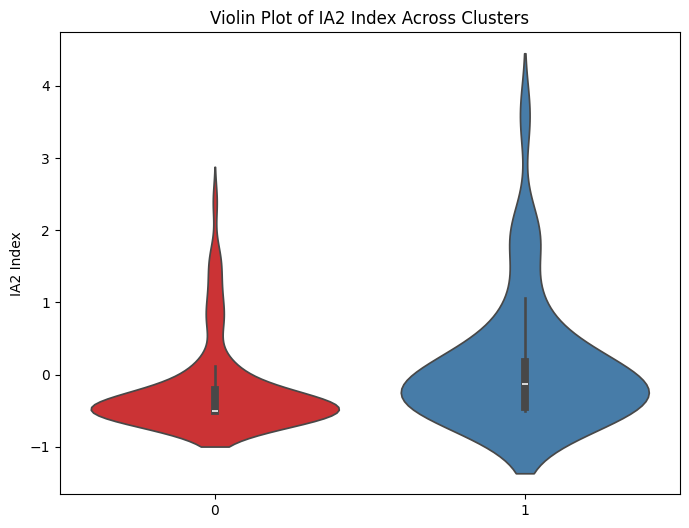

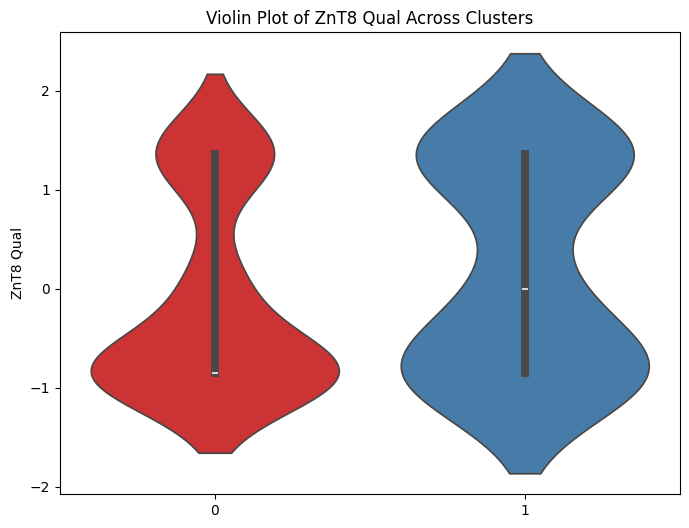

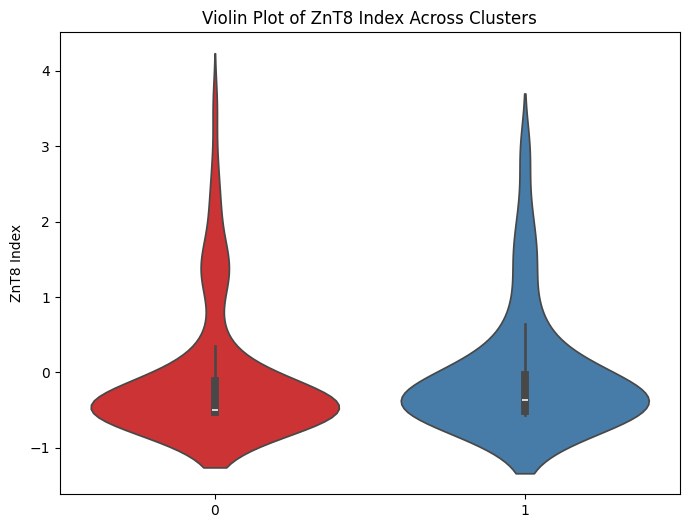

Contigence table of IA2 against cluster membership: 
col_0      0   1
IA2 Qual        
False     56  11
True      28  27


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

p_values_antibody = []

for column in antibody_features.columns:
    groups = [antibody_features[cluster_labels == c][column] for c in np.unique(cluster_labels)]
    _, p_value = f_oneway(*groups)  # f_oneway returns the F-statistic and p-value
    p_values_antibody.append(p_value)

p_values_antibody_df = pd.DataFrame({'Feature': antibody_features.columns, 'p-value': p_values_antibody})

print(p_values_antibody_df)


# Plot the p-values
plt.figure(figsize=(10, 6))
plt.barh(p_values_antibody_df['Feature'], p_values_antibody_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Antibody Features')
plt.title('ANOVA p-values for Antibody Features Across Clusters')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.grid(True)
plt.show()

significant_antibody_features = p_values_antibody_df[p_values_antibody_df['p-value'] < 0.05/6]

print("Antibody features with p-value < 0.05:")
print(significant_antibody_features['Feature'])



import warnings
warnings.filterwarnings("ignore")
for column in antibody_features.columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=cluster_labels_hc, y=column, data=features_antibody, palette='Set1')
    plt.title(f'Violin Plot of {column} Across Clusters')
    plt.show()


# Create a contrast table for the IA2 Qual feature
contrast_table = pd.crosstab(antibody_features['IA2 Qual']>0, cluster_labels)

print("Contigence table of IA2 against cluster membership: ")
print(contrast_table)

Finally, we examine the relationship between the HC clusters and the ancestry information. We found that the associations between the clusters and the ancestry information are not statistically significant.

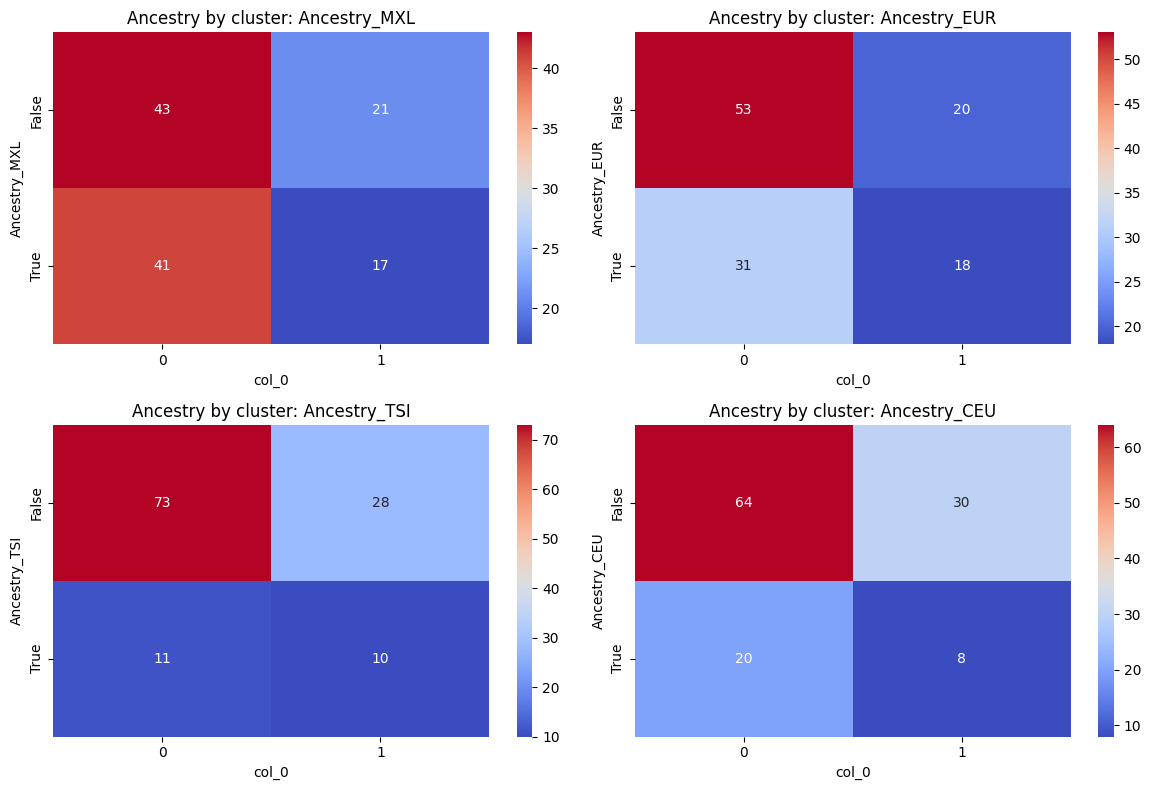


Chi-square Test Results for European ancestry versus clustering labels:
p-value: 0.372. Not significant


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

ancestry_features = features_ancestry.drop(columns=['Cluster'])
cluster_labels = cluster_labels_hc

contrast_tables = []
for column in ancestry_features.columns:
    contrast_table = pd.crosstab(ancestry_features[column]>0, cluster_labels)
    contrast_tables.append(contrast_table)


    
# Plot the contrast tables
plt.figure(figsize=(12, 8))
for i, table in enumerate(contrast_tables):
    #feature name of i-th feature
    feature_name = ancestry_features.columns[i]
    plt.subplot(2, 2, i + 1)
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Ancestry by cluster: {feature_name}')
plt.tight_layout()
plt.show()

contrast_table = contrast_tables[1]


# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contrast_table)


print("\nChi-square Test Results for European ancestry versus clustering labels:")
print(f"p-value: {p_value:.3f}. Not significant")


In conclusion, the HC clustering results were largely driven by MHC region SNPs and IA2 antibody levels.

## Soft-threshold Clustering

### Fuzzy C-Means Clustering

* Soft Clustering: Instead of assigning each point to a single cluster, FCM computes membership probabilities for each point across all clusters. This is useful when there are no clear boundaries between clusters.

* Membership Matrix: FCM outputs a membership matrix where each data point has a numerical membership value every cluster, instead of categorical clsuter assignments.

* Flexibility: Points that are in overlapping regions between clusters will have high membership in multiple clusters.

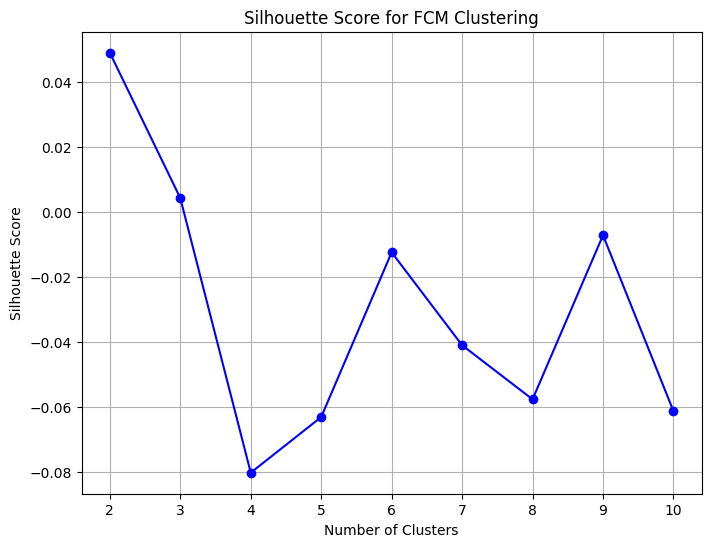

The optimal number of clusters is: 2


In [ ]:
# pip install fuzzy-c-means

import numpy as np
import matplotlib.pyplot as plt
from fcmeans import FCM
from sklearn.metrics import silhouette_score
import pandas as pd

features_scaled_dat = pd.read_csv('results/2025_scaled_features_outliers.csv')

features_scaled = features_scaled_dat.values  # Converts DataFrame to NumPy array



#set a random seed
np.random.seed(42)

range_n_clusters = range(2, 11)
silhouette_scores = []

# Loop over different numbers of clusters
for n_clusters in range_n_clusters:
    # Step 1: Perform Fuzzy C-Means clustering
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(features_scaled)
    
    # Step 2: Convert soft memberships to hard labels by taking the highest membership value
    fcm_labels = fcm.predict(features_scaled)  # Hard cluster labels
    
    # Step 3: Calculate silhouette score based on hard labels
    silhouette_avg = silhouette_score(features_scaled, fcm_labels)
    silhouette_scores.append(silhouette_avg)

# Step 4: Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for FCM Clustering')
plt.grid(True)
plt.show()

# Step 5: Find the optimal number of clusters (maximum silhouette score)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")


We conducted Fuzzy C-Means clustering on the data with the optimal number of clusters = 2. Note that to achive stable clustering results we repeated FCM multiple times (N=50) and averaged the results for more stable outcomes. We then visualize the clustering results using PCA.

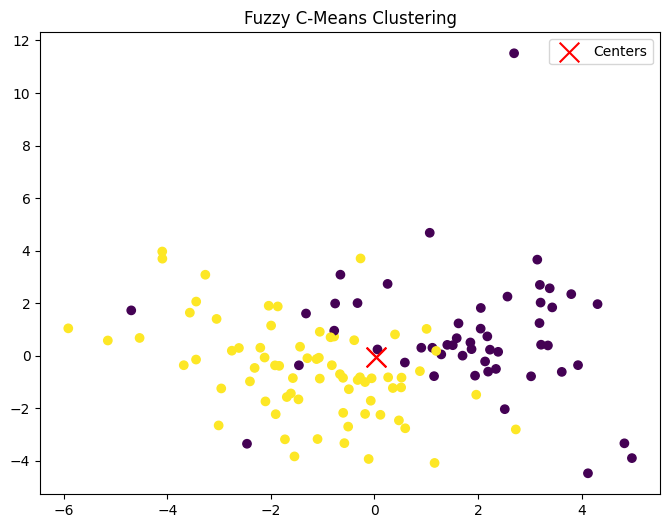

Membership values for first few points:
[[0.50000001 0.49999999]
 [0.49999989 0.50000011]
 [0.49999987 0.50000013]
 [0.50000011 0.49999989]
 [0.5000002  0.4999998 ]]


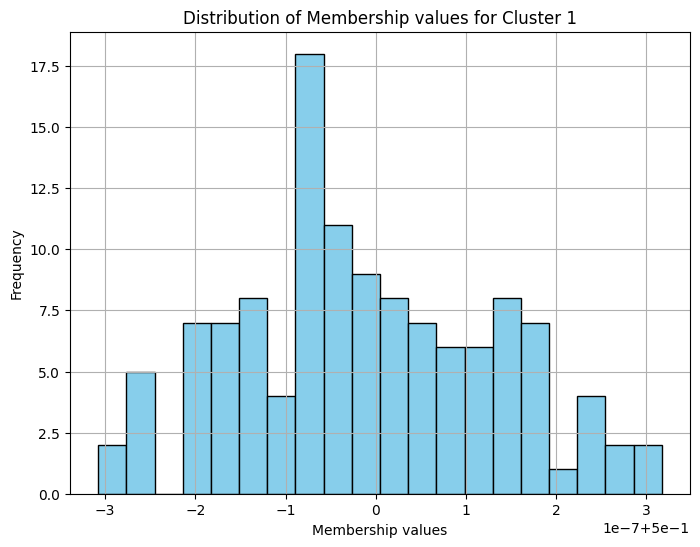

In [ ]:
# pip install fuzzy-c-means

import numpy as np
import matplotlib.pyplot as plt
from fcmeans import FCM
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score


# Set a random seed globally
np.random.seed(42)

n_clusters = 2
best_labels = None
best_membership = None
best_silhouette = -1  # Start with a low silhouette score

# Run FCM multiple times
for _ in range(50):
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(features_scaled)
    fcm_labels = fcm.predict(features_scaled)
    current_membership = fcm.u  # Soft membership matrix
    fcm_centers = fcm.centers
    
    # Calculate silhouette score for evaluation
    silhouette_avg = silhouette_score(features_scaled, fcm_labels)
    
    # Update if this run has the best 
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_labels = fcm_labels
        best_centers = fcm_centers
        best_membership = current_membership

# Assign the best membership matrix
membership_matrix = best_membership
fcm_labels = best_labels
fcm_centers = best_centers

# Step 3: Visualize the clustering using PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=fcm_labels, cmap='viridis')
plt.scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker='x', s=200, color='red', label='Centers')
plt.title('Fuzzy C-Means Clustering')
plt.legend()
plt.show()

print("Membership values for first few points:")
print(membership_matrix[:5])

plt.figure(figsize=(8, 6))
plt.hist(membership_matrix[:, 0], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Membership values')
plt.ylabel('Frequency')
plt.title('Distribution of Membership values for Cluster 1')
plt.grid(True)
plt.show()

pd.DataFrame(membership_matrix).to_csv('results/2025_fcm_membership.csv', index=False)

membership_matrix = pd.read_csv('results/2025_fcm_membership.csv').values


Note that the cluster centers from the FCM are largely overlapping on each other. It denotes the soft clustering nature of FCM and the lack of clear boundaries between the two clusters.

To proceed, we look into the associations between the FCM cluster values and the clinical, genotype, and antibody data.

Note that with soft-threshold clustering, the cluster membership is not a binary value, but a continuous value. Therefore we test the association between the cluster membership and the clinical, genotype, and antibody data with T-test.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)
clinical_features = features_clinical.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in clinical_features.columns:
    X = sm.add_constant(clinical_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

# Create a DataFrame to store the results
regression_results = pd.DataFrame({
    'Feature': clinical_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

print(regression_results)


                      Feature   p-value     R-squared
0                 Cluster_age  0.557481  2.875195e-03
1     Cluster_diabete_history  0.428800  5.225334e-03
2   Cluster_diabetes_siblings  0.042102  3.397857e-02
3     Cluster_diabetes_father  0.743156  8.980967e-04
4     Cluster_diabetes_mother  0.778650  6.609049e-04
5    Cluster_diabetes_parents  0.901632  1.278314e-04
6     Cluster_family_diabetes  0.830661  3.826301e-04
7              Cluster_height  0.287248  9.431891e-03
8              Cluster_weight  0.145312  1.759032e-02
9             Cluster_insulin  0.284516  9.538963e-03
10                Cluster_A1c  0.147297  1.741960e-02
11                Cluster_sex  0.998920  1.532718e-08


The associations between the FCM clusters and the clinical features are not sigificant under pvalue < 0.05 after bonferroni correction. Note that Cluster_diabetes_siblings have p-value 0.04, but it is not significant after bonferroni correction.



Next, we explore the relationship between the FCM clusters and the genotype data. We first show the genotype features with significant p-values under 0.05 after Bonferroni correction for multiple testing.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)

genotype_features = features_genotype.drop(columns=['Cluster'])

n_genotypes = len(genotype_features.columns)

cluster_labels_fcm = membership_matrix[:, 0]

p_values = []
r_squared = []

for column in genotype_features.columns:
    X = sm.add_constant(genotype_features[column])
    model = sm.OLS(cluster_labels_fcm, X).fit()
    # Only append the feature's p-value if there are at least two parameters.
    if len(model.pvalues) > 1:
        p_values.append(model.pvalues[1])
        r_squared.append(model.rsquared)
    else:
        # Append NaN 
        p_values.append(np.nan)
        r_squared.append(np.nan)

# DataFrame to store the results
regression_results = pd.DataFrame({
    'Feature': genotype_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

# Print the siginificant features with pvalue < 0.05/216
print("Genotype features with p-value < 0.05 after Bonferroni correction for multiple testing:")
print(regression_results[regression_results['p-value'] < 0.05/n_genotypes])

 #filter the significant features with pvalue < 0.05/216
significant_genotype_features = regression_results[regression_results['p-value'] < 0.05/n_genotypes]


Genotype features with p-value < 0.05 after Bonferroni correction for multiple testing:
   Feature       p-value  R-squared
6        6  2.488836e-05   0.138189
30      30  3.917754e-04   0.099848
31      31  2.268381e-04   0.107525
72      72  2.569697e-22   0.546059
73      73  7.039957e-31   0.672638
81      81  1.890387e-22   0.548360
82      82  9.267452e-31   0.671140
93      93  9.207742e-05   0.120115
94      94  3.199571e-05   0.134738


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# First, convert the 'Feature' column to integers
significant_genotype_features['Feature'] = significant_genotype_features['Feature'].astype(int)

# Now convert the column indices to SNP numbers
significant_genotype_features['SNP'] = significant_genotype_features['Feature'].apply(lambda x: (x // 3) + 1)

# Drop duplicate SNPs 
significant_snps = significant_genotype_features['SNP'].drop_duplicates()

# Print the unique SNPs corresponding to significant genotype features
print("Significant SNPs corresponding to p-value < 0.05 after Bonfferoni correction:")
print(significant_snps)

print(bim.loc[significant_snps - 1])


Significant SNPs corresponding to p-value < 0.05 after Bonfferoni correction:
6      3
30    11
72    25
81    28
93    32
Name: SNP, dtype: int64
   chrom        snp   cm        pos a0 a1   i
2      2  rs2111485  0.0  162254026  A  G   2
10     6  rs9266268  0.0   31358273  A  G  10
24     6  rs2395228  0.0   32655446  C  A  24
27     6  rs1049124  0.0   32659936  A  G  27
31     6  rs6934289  0.0   33077179  C  T  31


Note that we identified 5 SNPs significant assocaited with the soft-threshold clustering results. More importantly, the snps of rs2395228 and rs1049124 are also found significantly associated with soft-treshold clustering results in previous analysis. 

Next, we explore the relationship between the FCM clusters and the antibody levels. Significant associations found under pvalue < 0.05 after bonferroni correction for IA2 qual but not for IA2 index.

In [ ]:
#now test the association between the fcm labels and the antibody features
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

np.random.seed(42)

antibody_features = features_antibody.drop(columns=['Cluster'])
cluster_labels_fcm = membership_matrix[:, 0]


p_values = []
r_squared = []

for column in antibody_features.columns:
    X = sm.add_constant(antibody_features[column])  # Add a constant (intercept term)
    model = sm.OLS(cluster_labels_fcm, X).fit()  # Fit the linear regression model
    p_values.append(model.pvalues[1])  # Store the p-value of the feature
    r_squared.append(model.rsquared)  # Store the R-squared value

regression_results = pd.DataFrame({
    'Feature': antibody_features.columns,
    'p-value': p_values,
    'R-squared': r_squared
})

print(regression_results)


       Feature   p-value  R-squared
0   96GAD Qual  0.922001   0.000080
1  96GAD Index  0.163823   0.016091
2     IA2 Qual  0.005548   0.062336
3    IA2 Index  0.130179   0.018984
4    ZnT8 Qual  0.334821   0.007753
5   ZnT8 Index  0.864739   0.000243


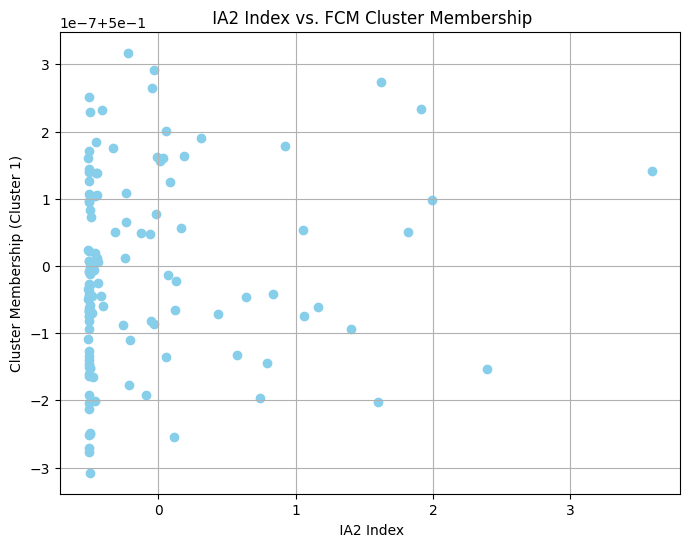

In [99]:


#we draw the scatterplot of the IA2 Index  versus the cluster_labels_fcm
plt.figure(figsize=(8, 6))
plt.scatter(features_antibody['IA2 Index'], cluster_labels_fcm, color='skyblue')
plt.xlabel(' IA2 Index')
plt.ylabel('Cluster Membership (Cluster 1)')
plt.title(' IA2 Index vs. FCM Cluster Membership')
plt.grid(True)
plt.show()




Finally, we examine the relationship between the FCM clusters and the ancestry information. We found that the associations between the clusters and the ancestry information are not statistically significant.

In [ ]:
from scipy.stats import ttest_ind

# Prepare a list to store results
results = []



# Loop through each column in ancestry_features
for column in ancestry_features.columns:
    group_1 = cluster_labels[ancestry_features[column] > 0 ]
    group_0 = cluster_labels[ancestry_features[column] < 0]
    
    # Perform the t-test
    t_stat, p_value = ttest_ind(group_1, group_0, equal_var=False)  # Welch's t-test
    results.append({'Feature': column, 'T-statistic': t_stat, 'P-value': p_value})

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='P-value').reset_index(drop=True)

print(results_df)

        Feature  T-statistic   P-value
0  Ancestry_TSI     1.653700  0.109854
1  Ancestry_EUR     1.070768  0.286923
2  Ancestry_MXL    -0.414628  0.679158
3  Ancestry_CEU    -0.336115  0.738346


In conclusion, the Fuzzy C-Means clustering results were largely driven by the MHC region SNPs which can be replicated from the previous analysis. However, notice that the Fuzzy C-Means clustering membership is not a binary assignment of clusters, but a continuous value of membership probabilities between two clusters.